# Random Forest, SVM, AB Classifiers on All Features

Import all necessary libraries, set matplotlib settings

In [18]:
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import precision_recall_curve, recall_score, accuracy_score, precision_score, confusion_matrix
import gzip
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("ggplot")
# %matplotlib inline

matplotlib.rcParams['figure.dpi'] = 200


#Set a random state to ensure replicability. Also, set cutoffs for our CNVs, since very small and very large CNVs are almost always benign and pathogenic respectively.

rand_state = 233
lower_bound = 2000
upper_bound = 5000000

#Initialize our data files/filenames for training

file = open('/content/sample_data/1.csv')
df = pd.read_csv(file, dtype=str)

#Drop columns that shouldn't be features, such as the genes, or chromsome number. This also includes repetitive elements that were classified as "Other" or "Unknown". Finally convert every value to a float."""

df.drop(['genes_in_proximity','chr', 'start', 'end', 'Unnamed: 0'], axis=1, inplace=True)
df.drop(['repeat_Other', 'repeat_Unknown'], axis=1, inplace=True)
df = df.astype(float)

#Since the values have been converted from a string to a float, we can do the size cutoffs

# cutoffs
df = df[df["size"] > lower_bound]
df = df[df["size"] < upper_bound]

#It seems scikit learn tends to like binary classification outputs of {0, 1}, not {-1, 1}. Also we need to seperate out the pathogenicity values, a.k.a. the values we want the classifier to output"""

df['pathogenicity'] = df['pathogenicity'].replace(-1, 0)
x_labels = df['pathogenicity'].values
df.drop(['pathogenicity'], axis=1, inplace=True)

#We need to create the gene and repetitive element density values

df['gene_density'] = df['number_of_genes_in_proximity'] / df['size'] * 100000
cols = [c for c in df.columns if c.lower()[:6] == 'repeat']
for col in cols:
    df[col + '_density'] = df[col] / df['size'] * 100000

#My gene_list feature was not as good a feature as I originally thought it would be, so I drop any gene_list feature columns here

cols = [c for c in df.columns if c.lower()[:4] == 'bioc' or c.lower()[:4] == 'kegg' or c.lower()[:5] == 'react']
df = df.drop(cols,axis=1)
to_be_scaled = df.columns

Define a function for drawing a precision-recall curve using matplotlib

In [19]:
def precision_recall_graph(precisions, recalls,Text):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title(Text)
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
    plt.ylim([0, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');


Define a function for finding the precision and threshold for a particular recall rate

In [20]:
def find_threshold_for_recall(precisions, recalls, thresholds, recalls_wanted,p_dict,t_dict,Yscore,Text):
    print(Text)
    for recall in recalls_wanted:
        closest_threshold = 0
        for i in range(len(recalls)):
            if recalls[i] - recall < 0:
                closest_threshold = thresholds[i]
                p_dict[recall].append(precisions[i])
                t_dict[recall].append(closest_threshold)
                break
        y_pred_adj = [1 if y >= closest_threshold else 0 for y in Yscore]
        print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        


Since we are running a k-fold cross validation, we end up with multiple different classifiers, feature importance rankings,  scaling constants, etc. Furthermore, we also end up with multiple different accuracy, precision, recall values. We need a way to store all the variables/classifiers for each run of the k-fold cross validation, so we can average them for analysis, and/or also use them when testing on another dataset

In [21]:
# a list of the accuracy for each classifier
accuracy_list = []
accuracy_list2 = []
accuracy_list3 = []
# a list of the average precision for each classifier
avg_precision_list = []
avg_precision_list2 = []
avg_precision_list3 = []
# a list of the recalls that are wanted for analysis
recalls_wanted = [0.90, 0.97, 0.99]

# stores a list of the thresholds needed for each classifier for each recall
thresh_dict = {}
for recall in recalls_wanted:
    thresh_dict[recall] = []
#2nd alg
thresh_dict2 = {}
for recall in recalls_wanted:
    thresh_dict2[recall] = []
#3rd alg
thresh_dict3 = {}
for recall in recalls_wanted:
    thresh_dict3[recall] = []

# stores a list of precisions for each classifier for each recall
precision_dict = {}
for recall in recalls_wanted:
    precision_dict[recall] = []
#for algorithm 2
precision_dict2 = {}
for recall in recalls_wanted:
    precision_dict2[recall] = []    

#for algorithm 3
precision_dict3 = {}
for recall in recalls_wanted:
    precision_dict3[recall] = []    

# stores each classifier trained per run
clf_list = []
clf_list2 = []
clf_list3 = []
clf_list_last=[] # best model saver after grid serch
# stores Logistic Regression coefficients
coef_list = []
coef_list2 = []
coef_list3 = []
# for box-cox scaling on 'size' feature
lambda_list = []
# for mean 0, std 1 scaling on every feature
scaler_list= []
scaler_list2= []
scaler_list3= []

#We need to initialize the k-fold cross validation

kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=rand_state)
kfold.get_n_splits(df, x_labels)
counter = 0

#We set SCALING to true, since Logistic Regression needs scaling and in general it is good practice

SCALING = True


The following is the complete training and validation loop

k_Fold 1 Results
RF confusion matrix *********
     pred_neg  pred_pos
neg      1868         2
pos        30       252
     pred_neg  pred_pos
neg      1849        21
pos         9       273
     pred_neg  pred_pos
neg      1727       143
pos         5       277
SVM confusion matrix *********
     pred_neg  pred_pos
neg      1860        10
pos        29       253
     pred_neg  pred_pos
neg      1715       155
pos         9       273
     pred_neg  pred_pos
neg      1272       598
pos         3       279
AB confusion matrix *********
     pred_neg  pred_pos
neg      1860        10
pos        32       250
     pred_neg  pred_pos
neg      1808        62
pos         9       273
     pred_neg  pred_pos
neg      1233       637
pos         3       279
k_Fold 2 Results
RF confusion matrix *********
     pred_neg  pred_pos
neg      1868         3
pos        29       252
     pred_neg  pred_pos
neg      1844        27
pos         9       272
     pred_neg  pred_pos
neg      1737       134
pos  

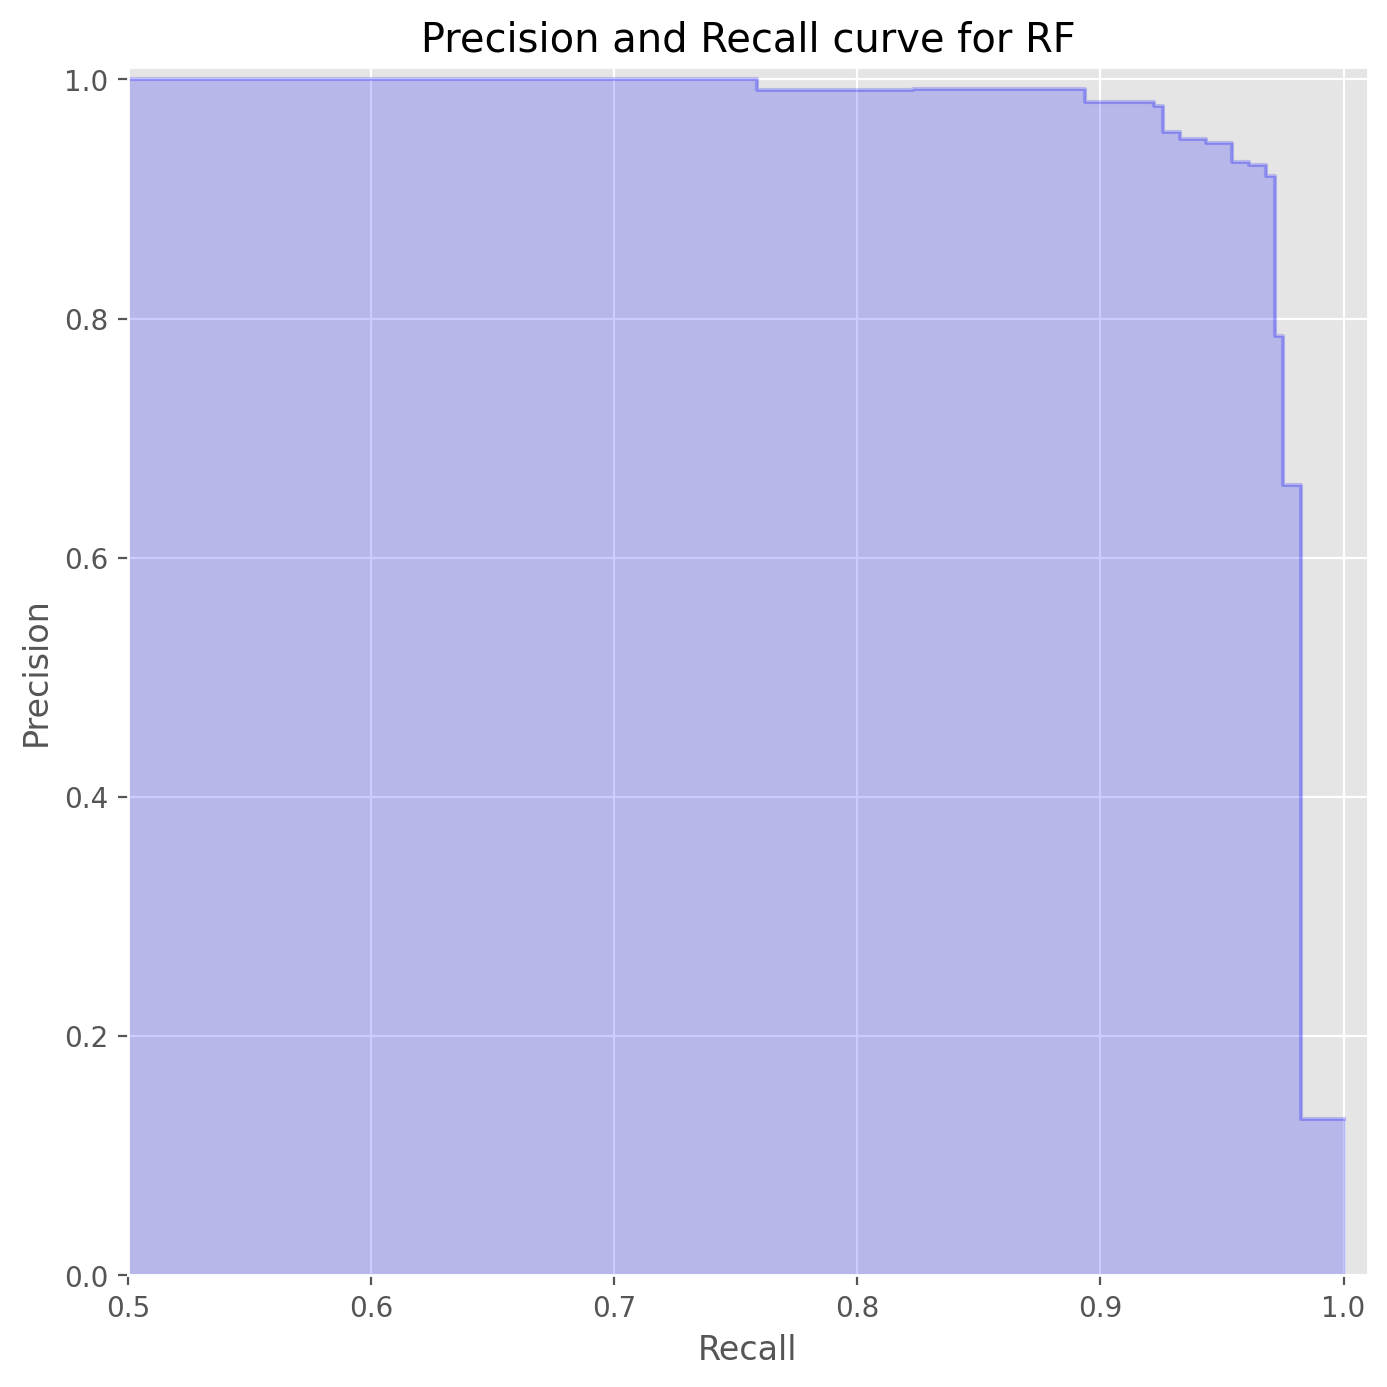

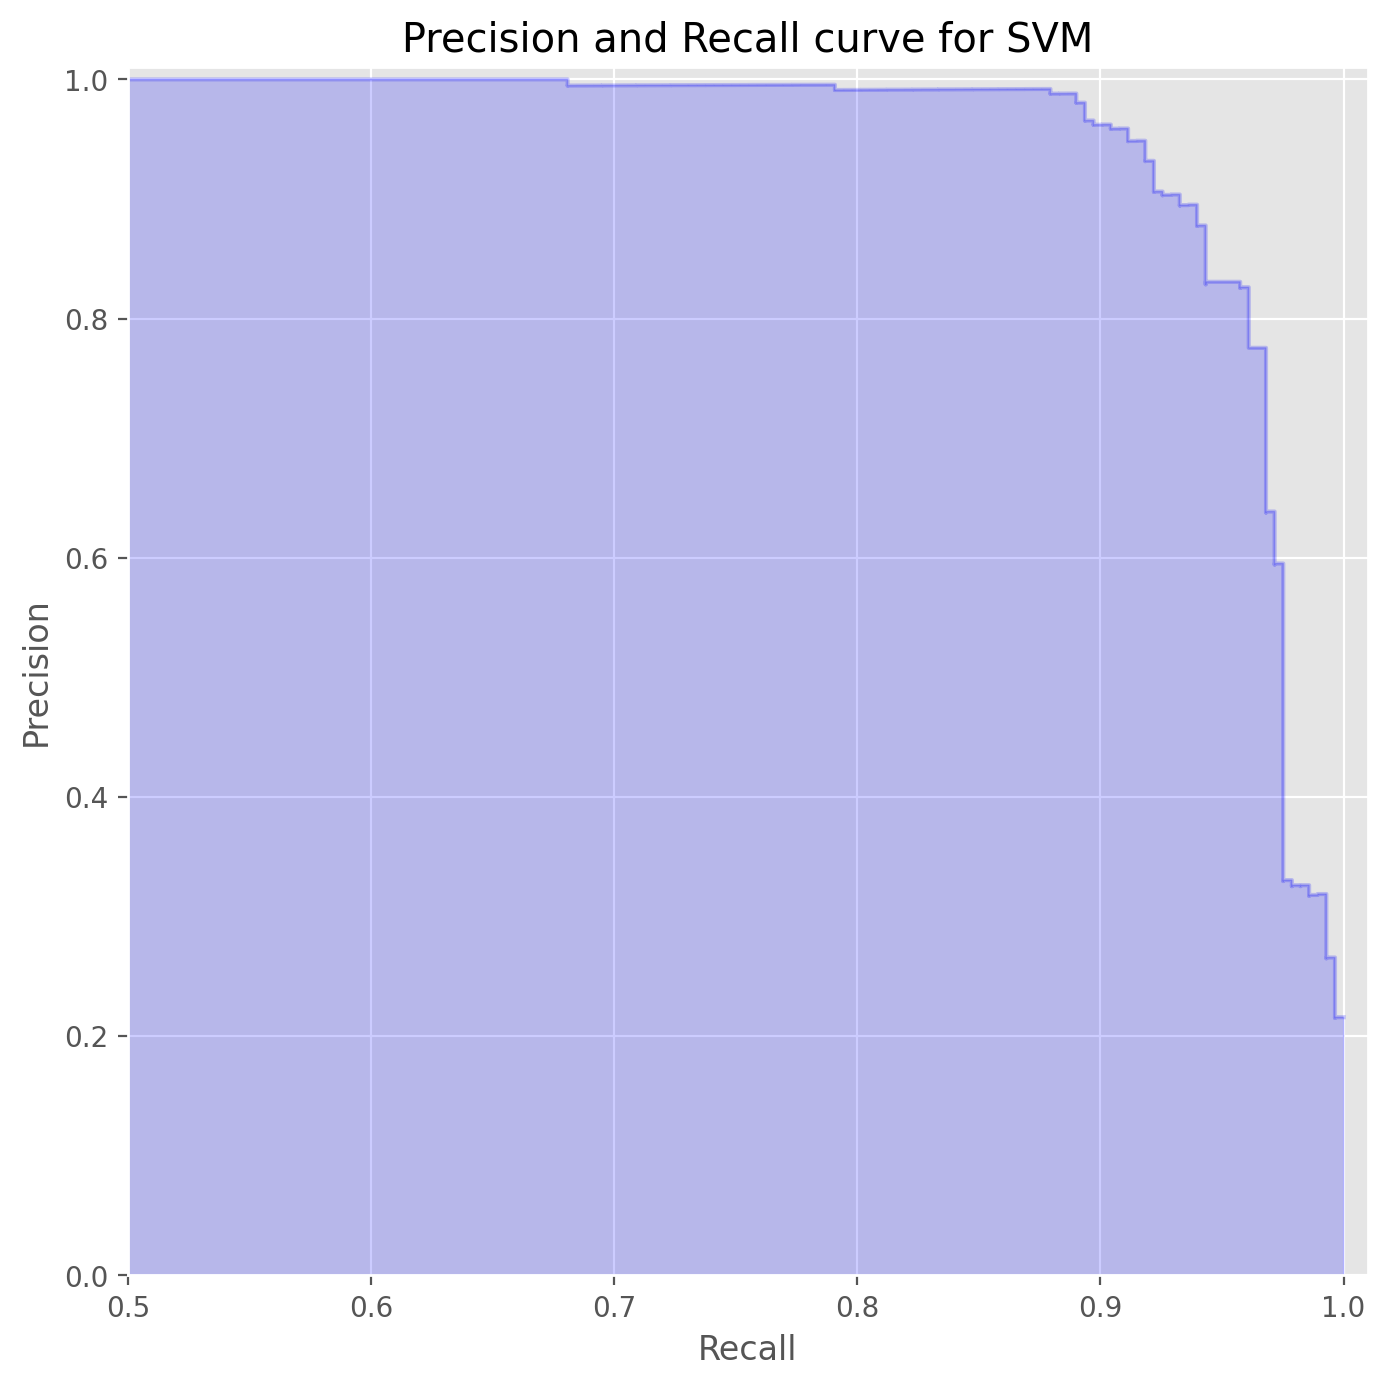

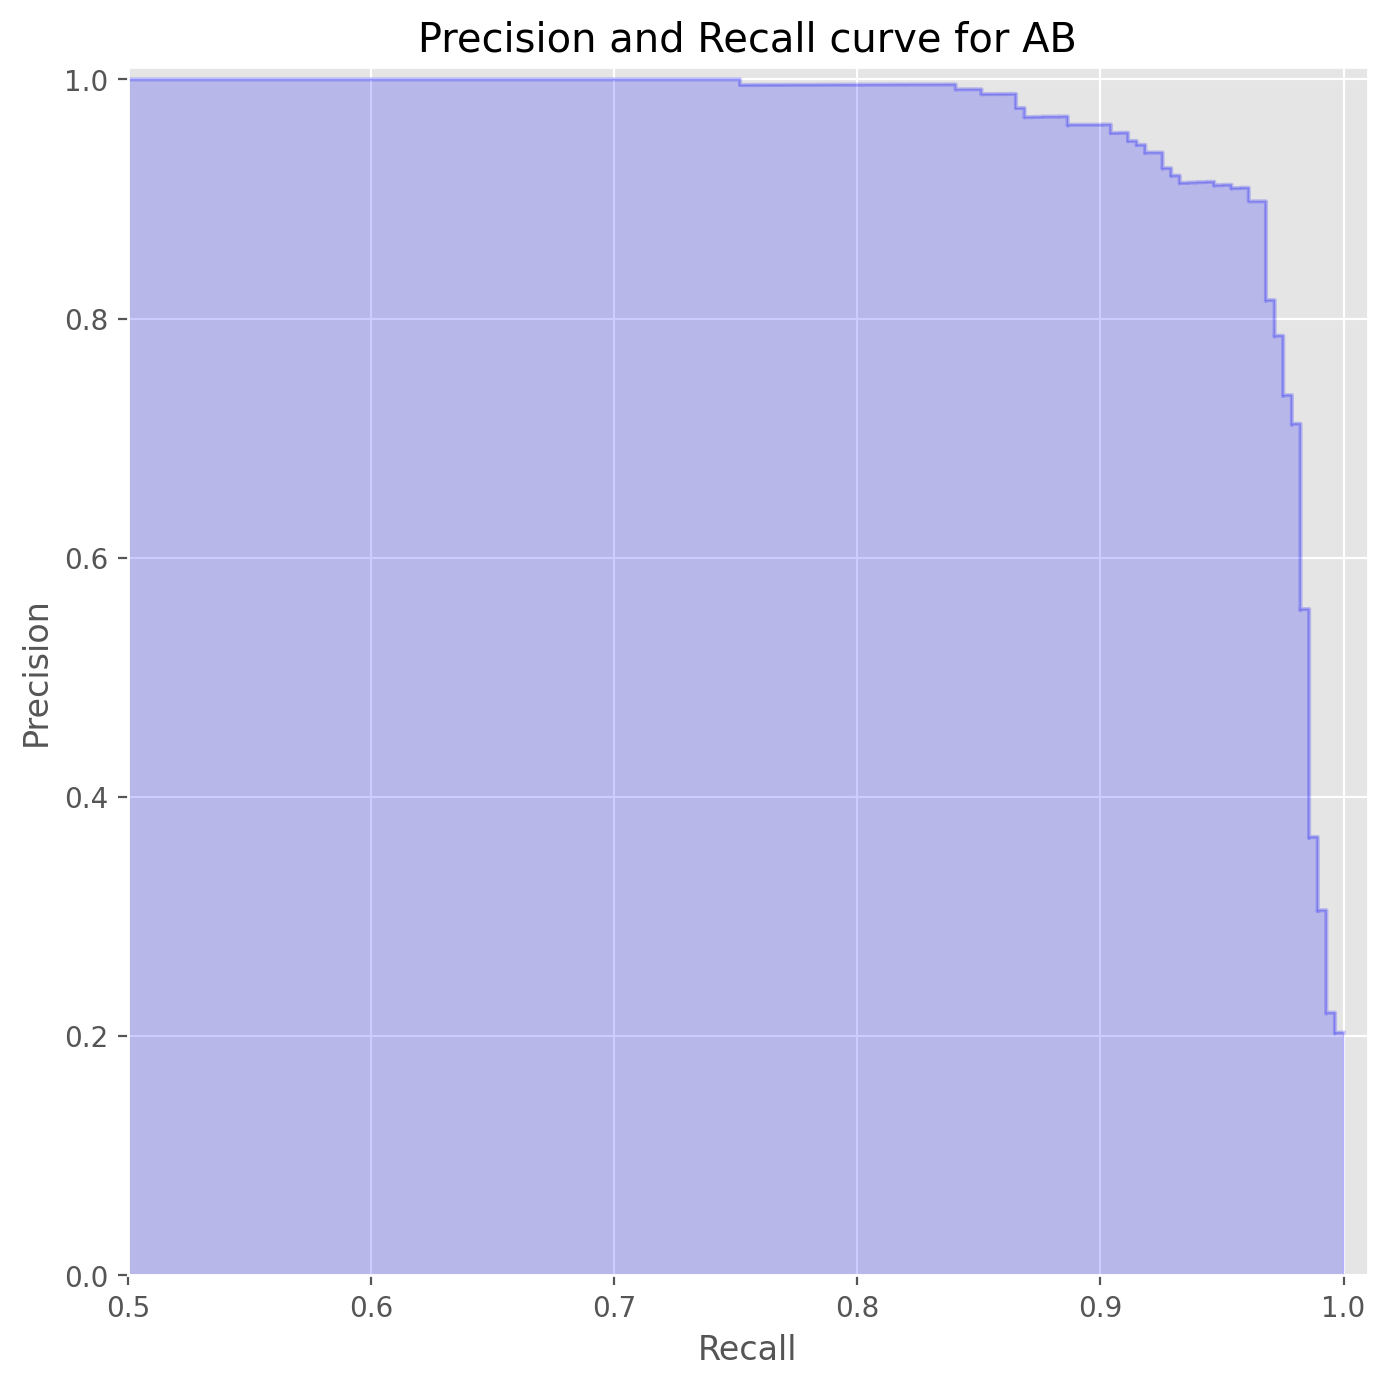

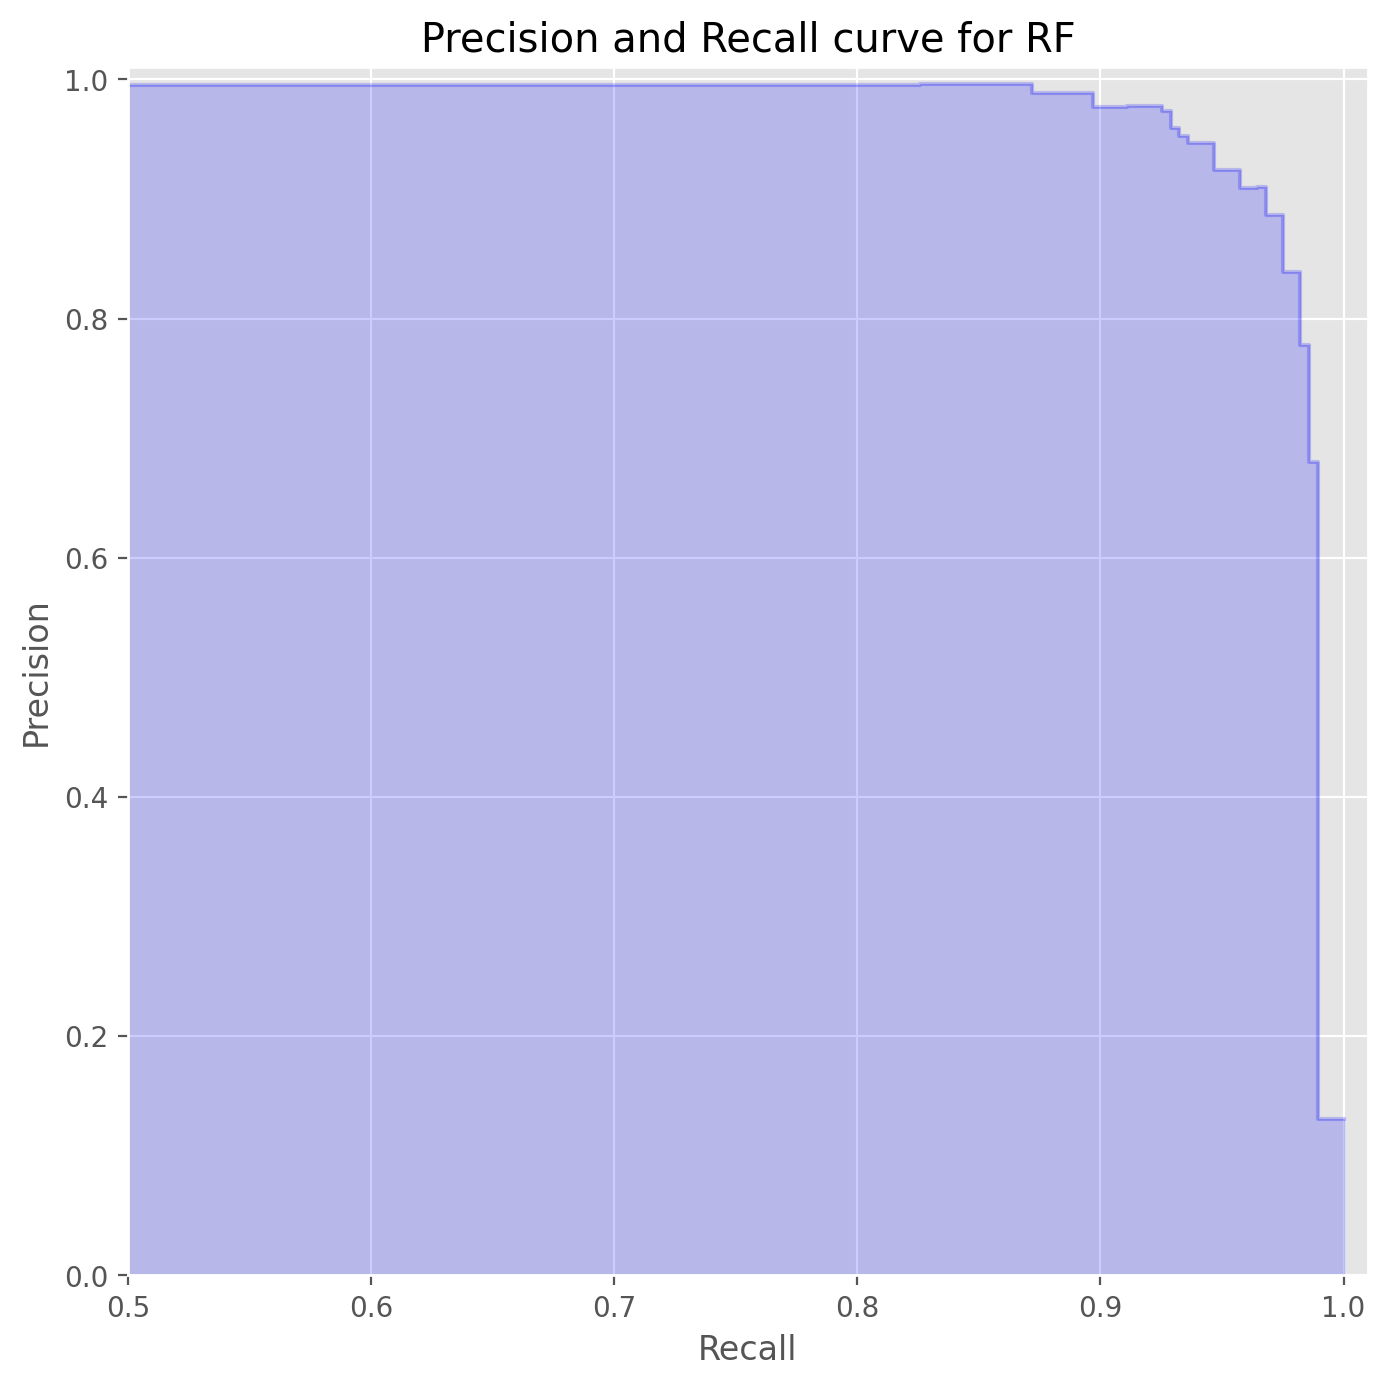

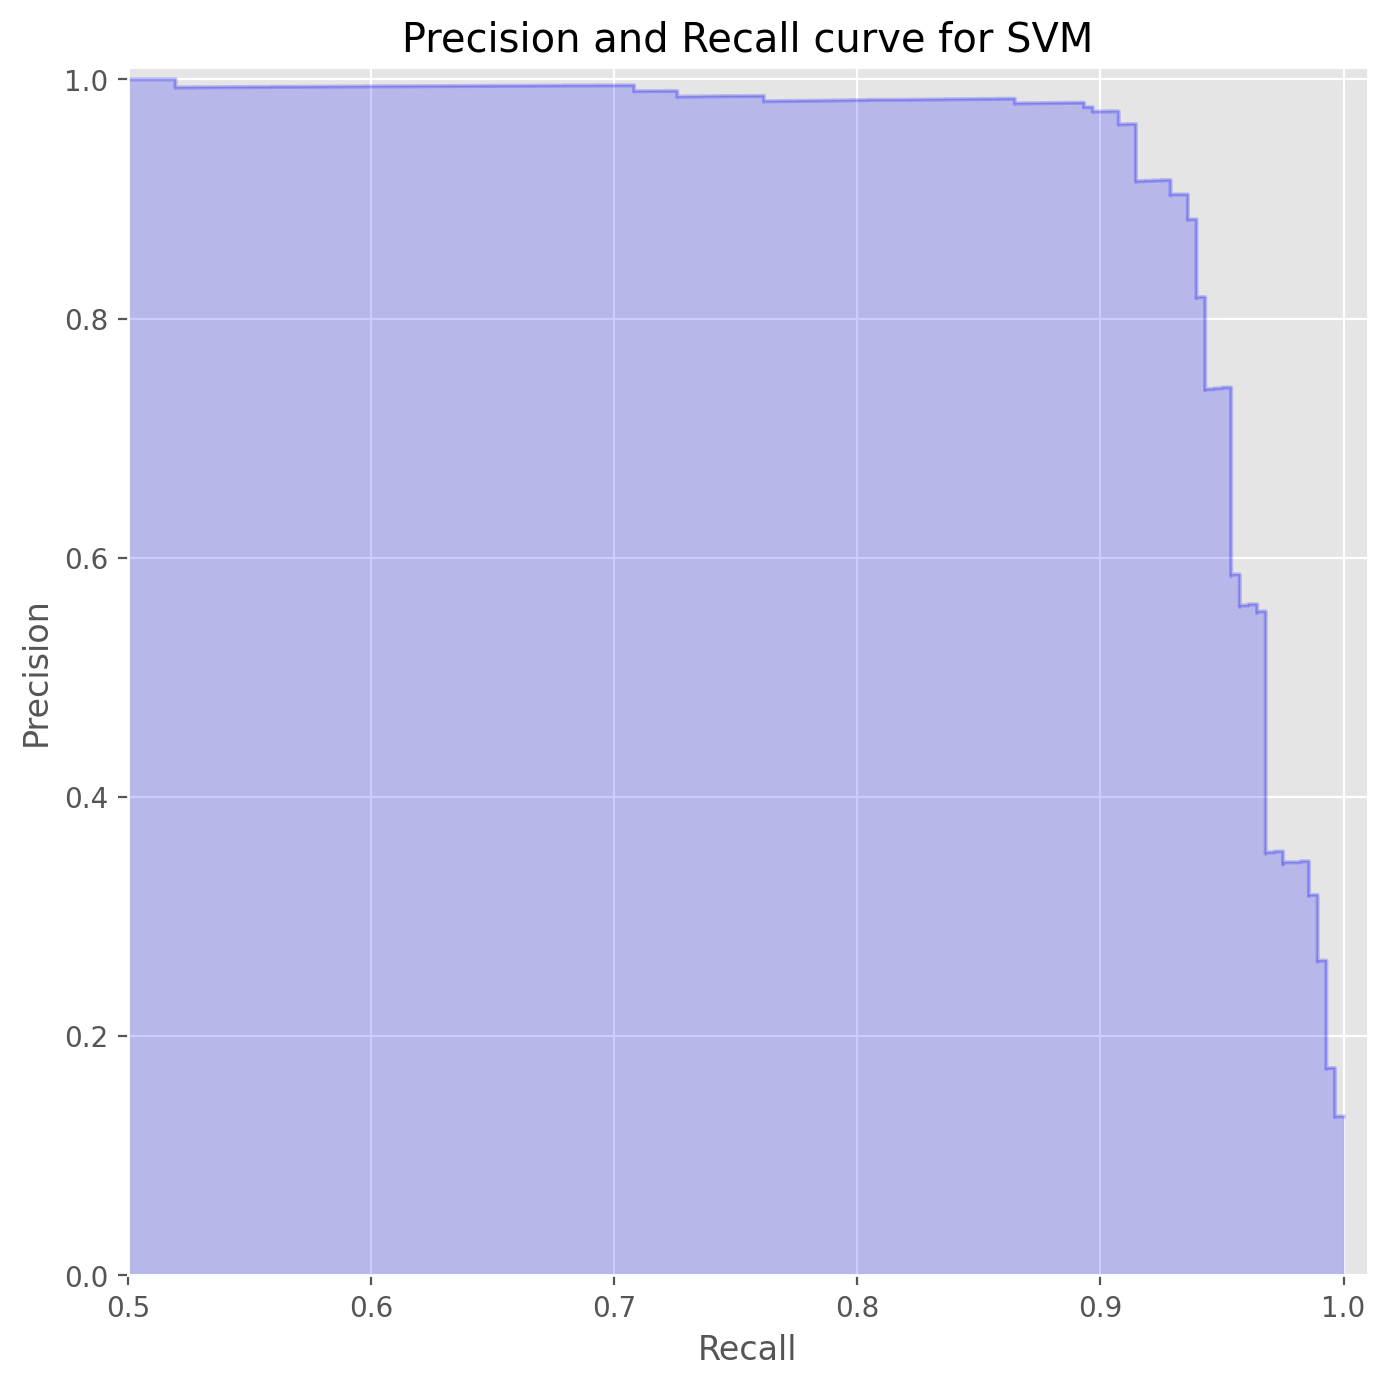

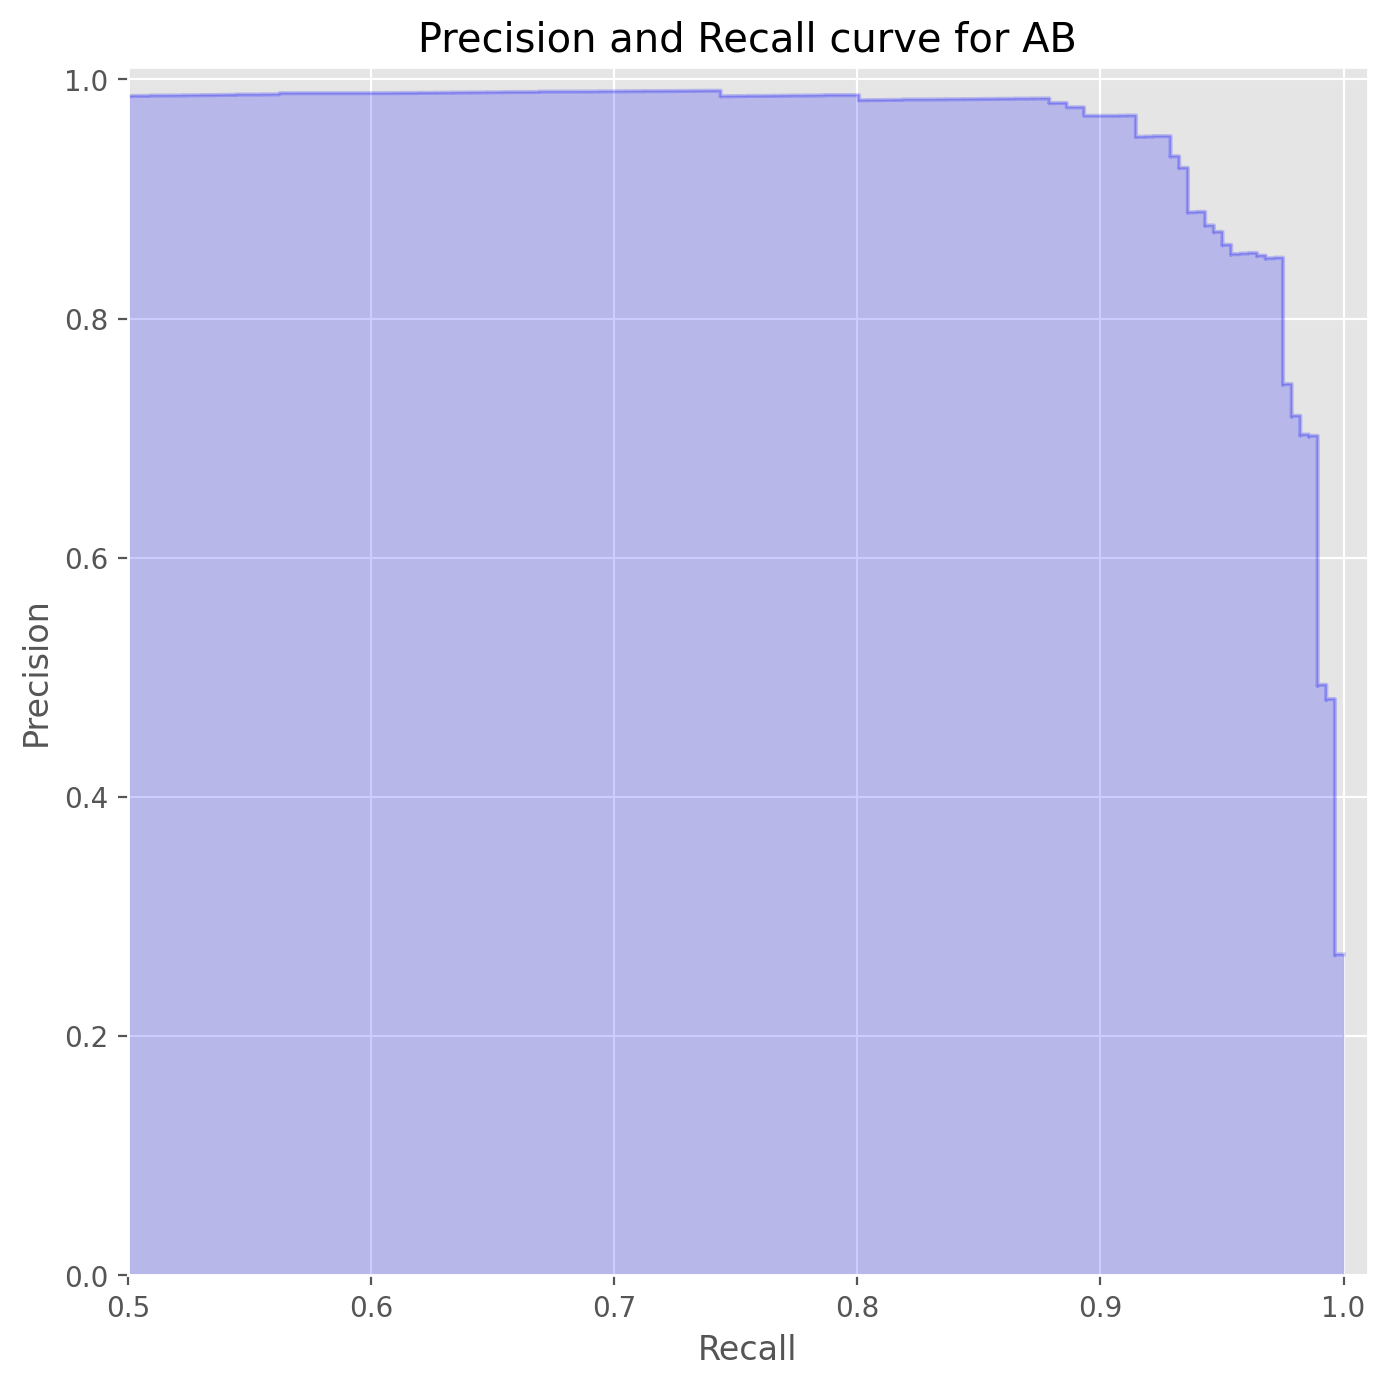

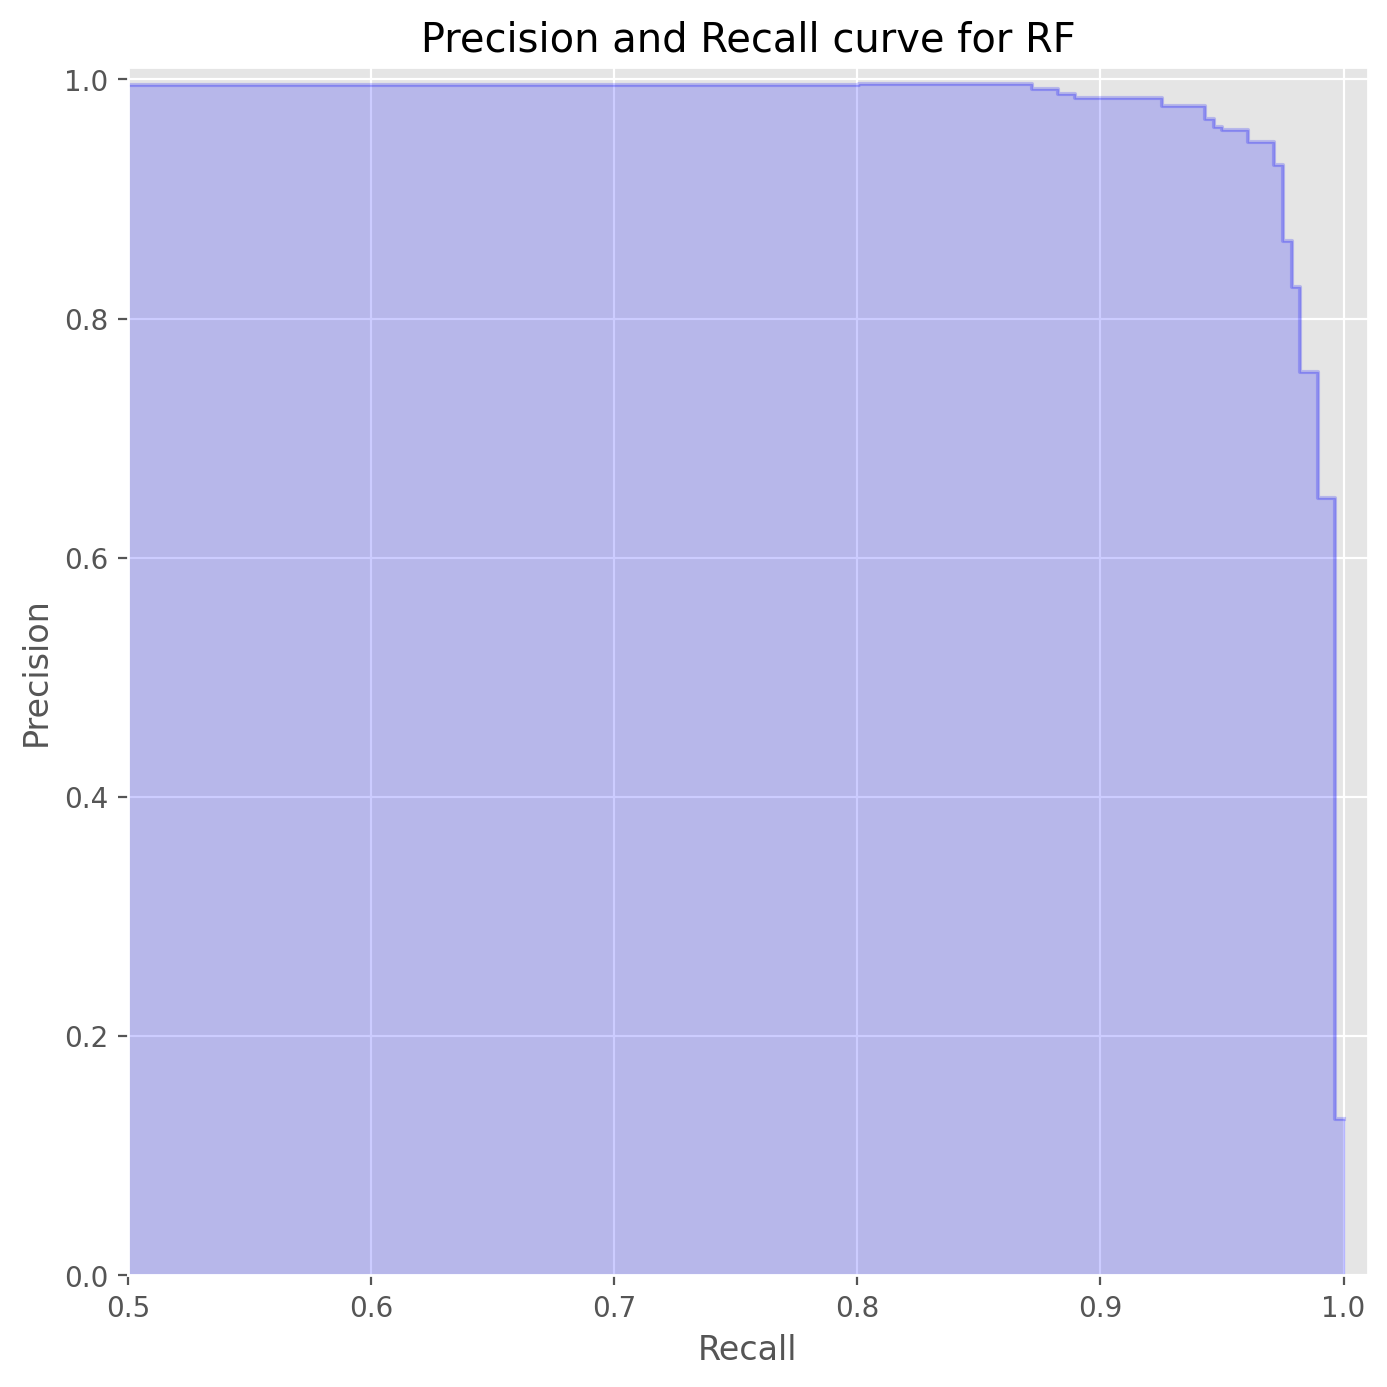

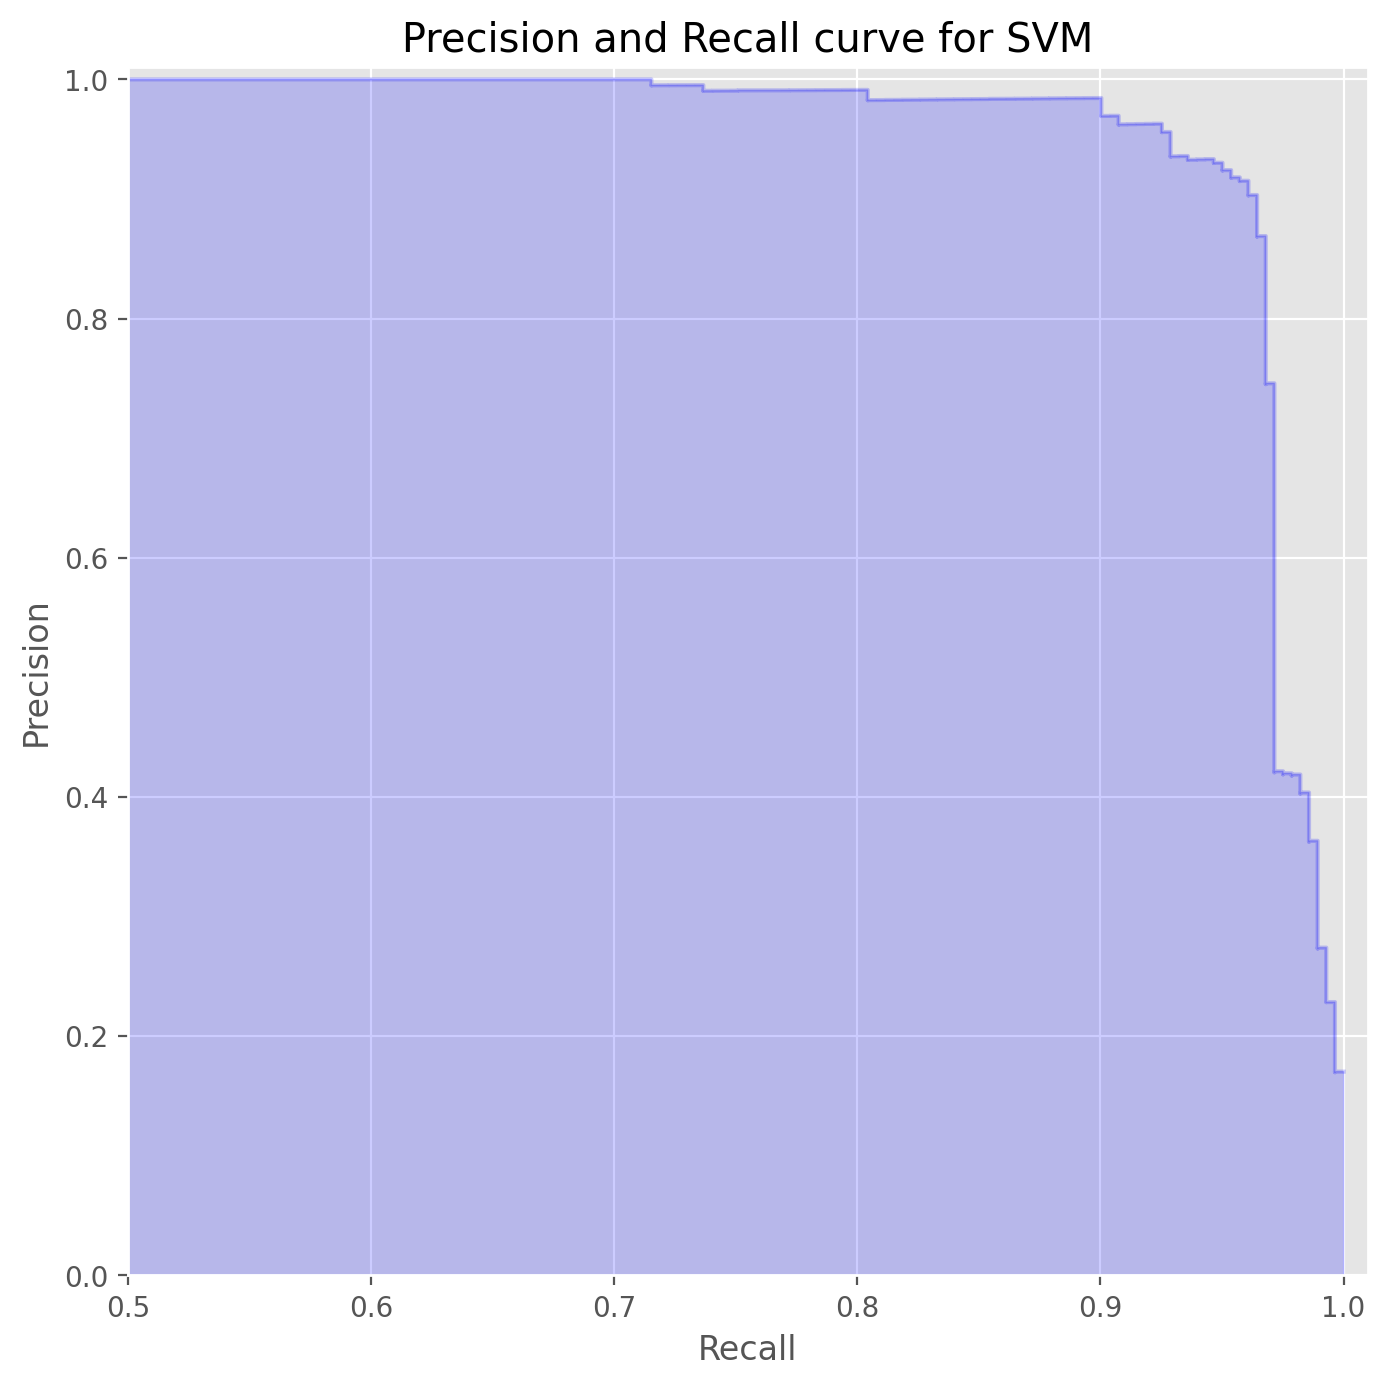

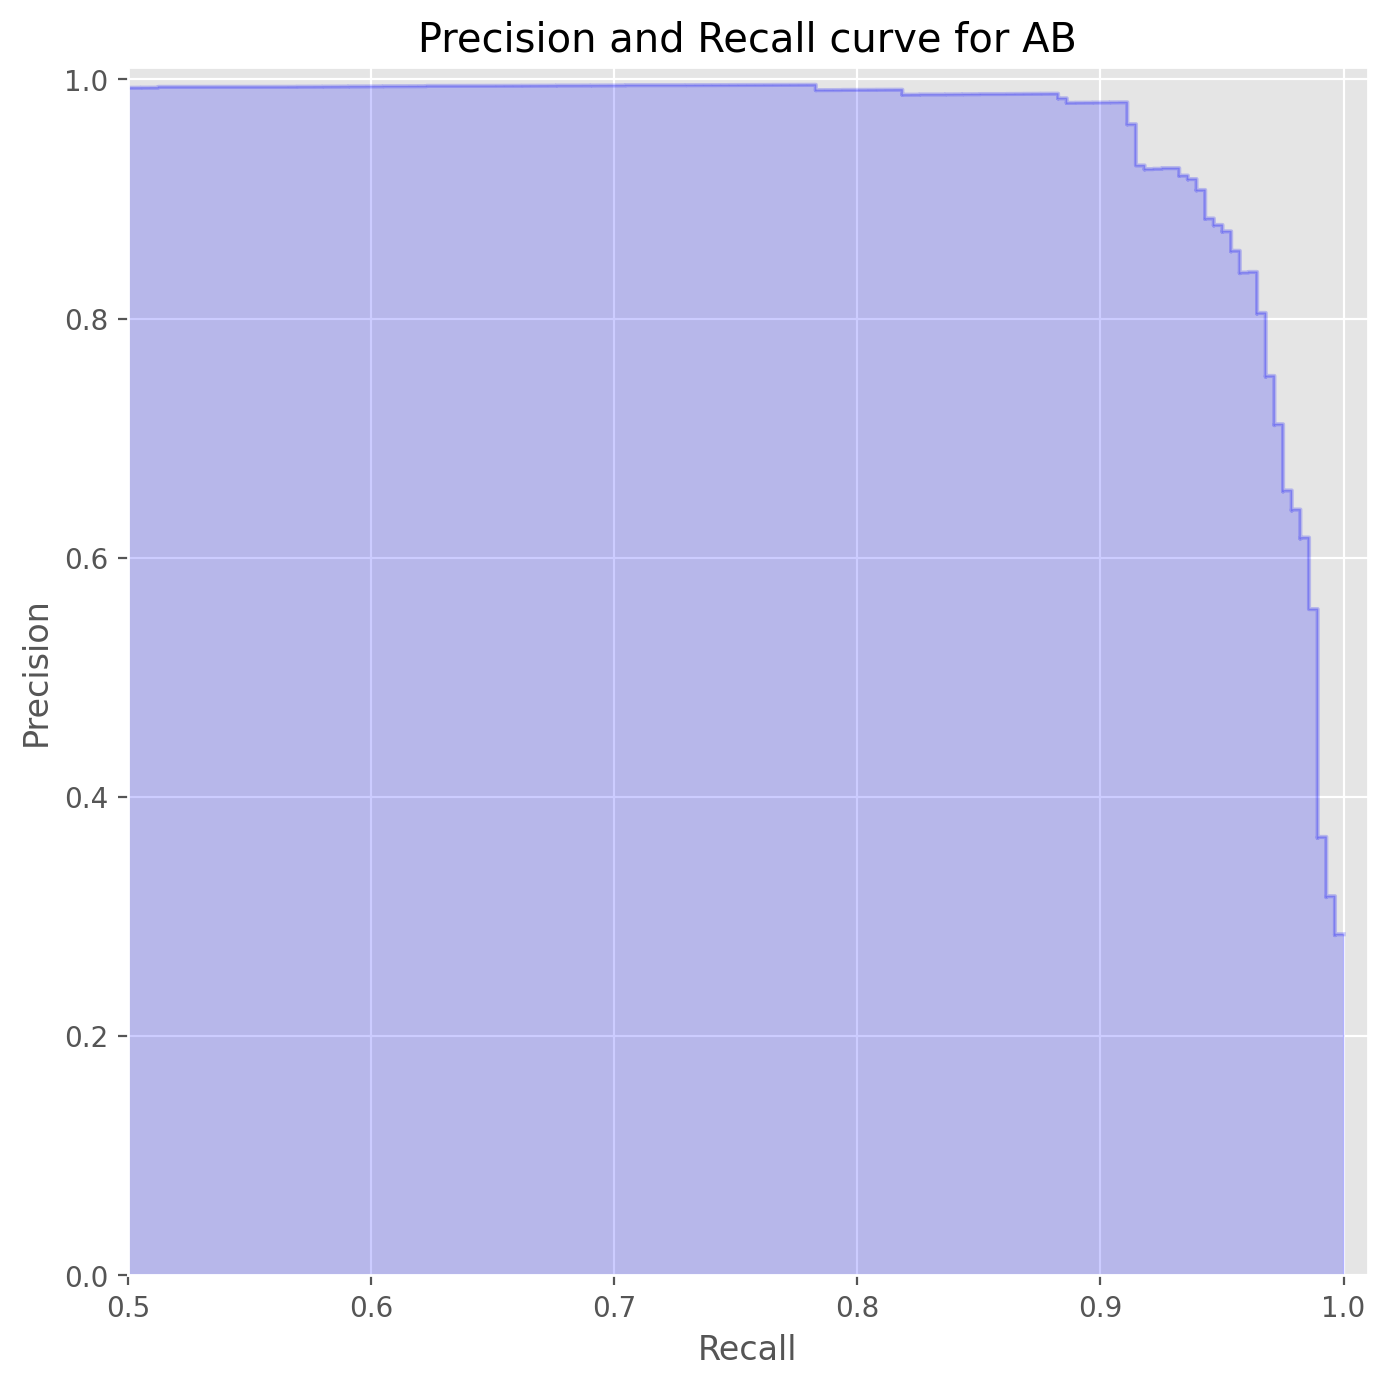

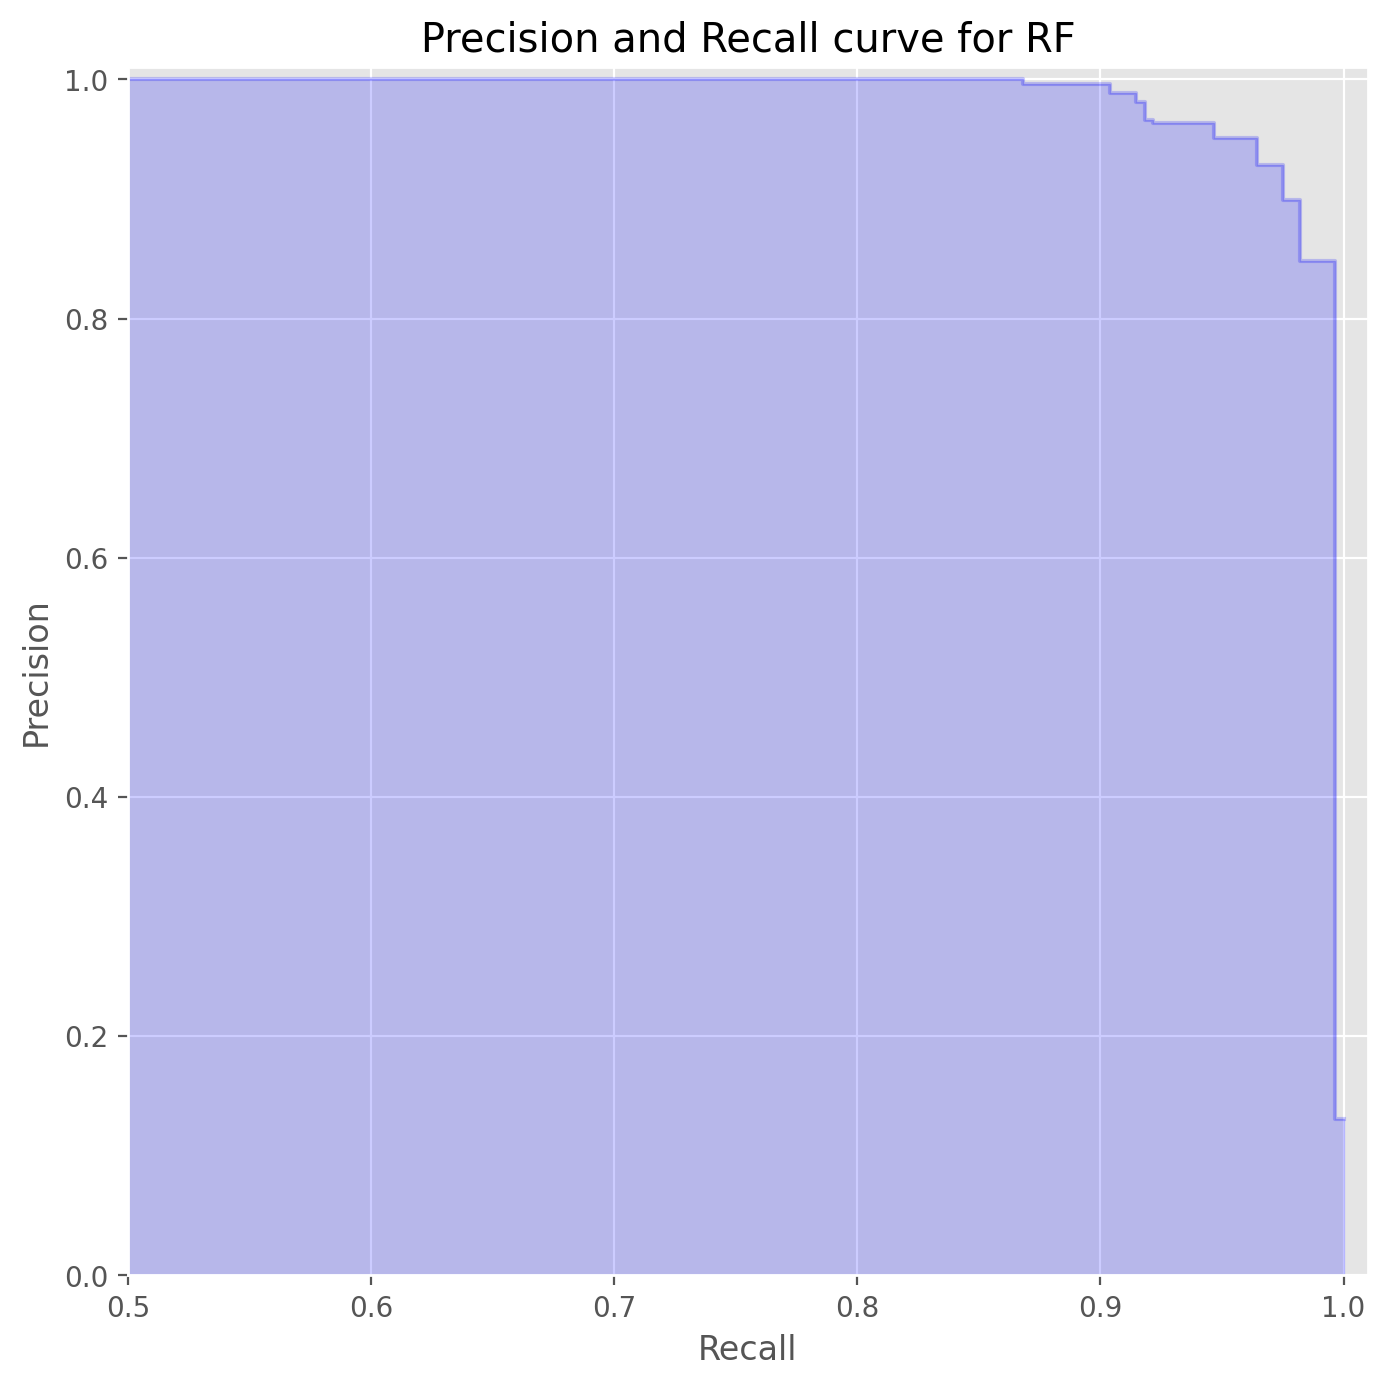

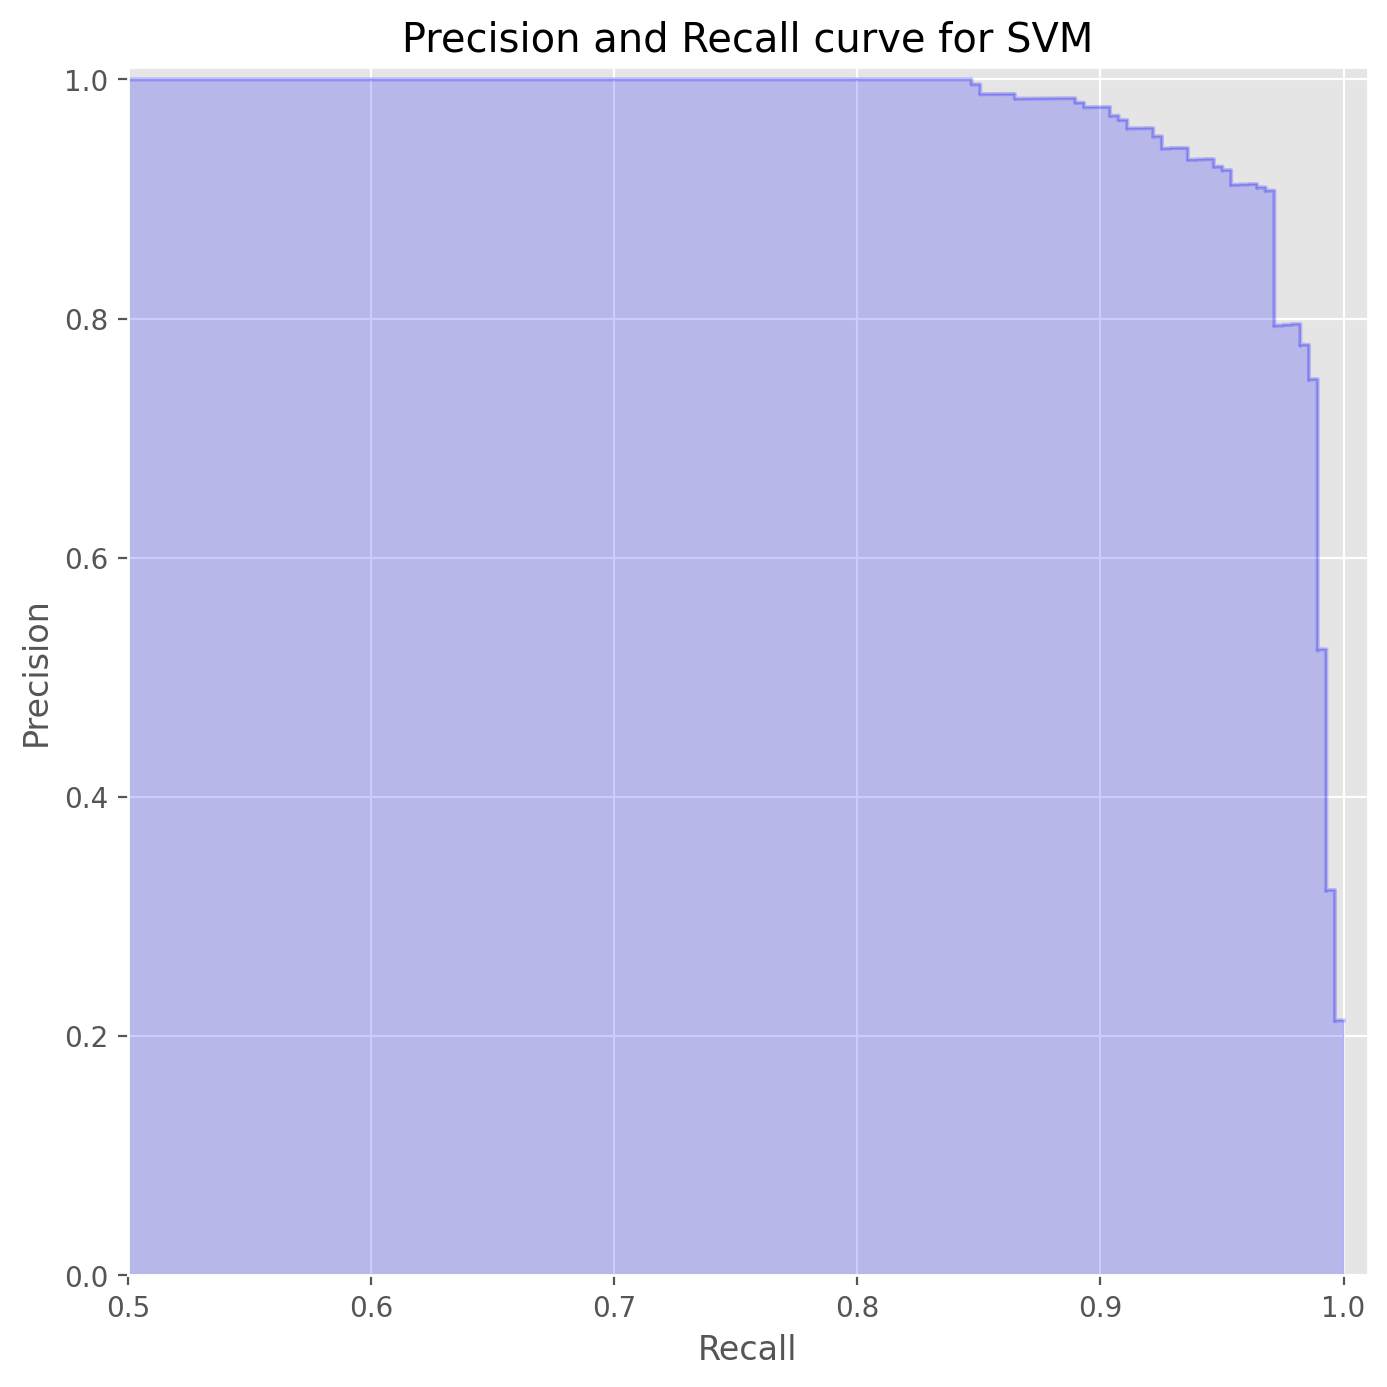

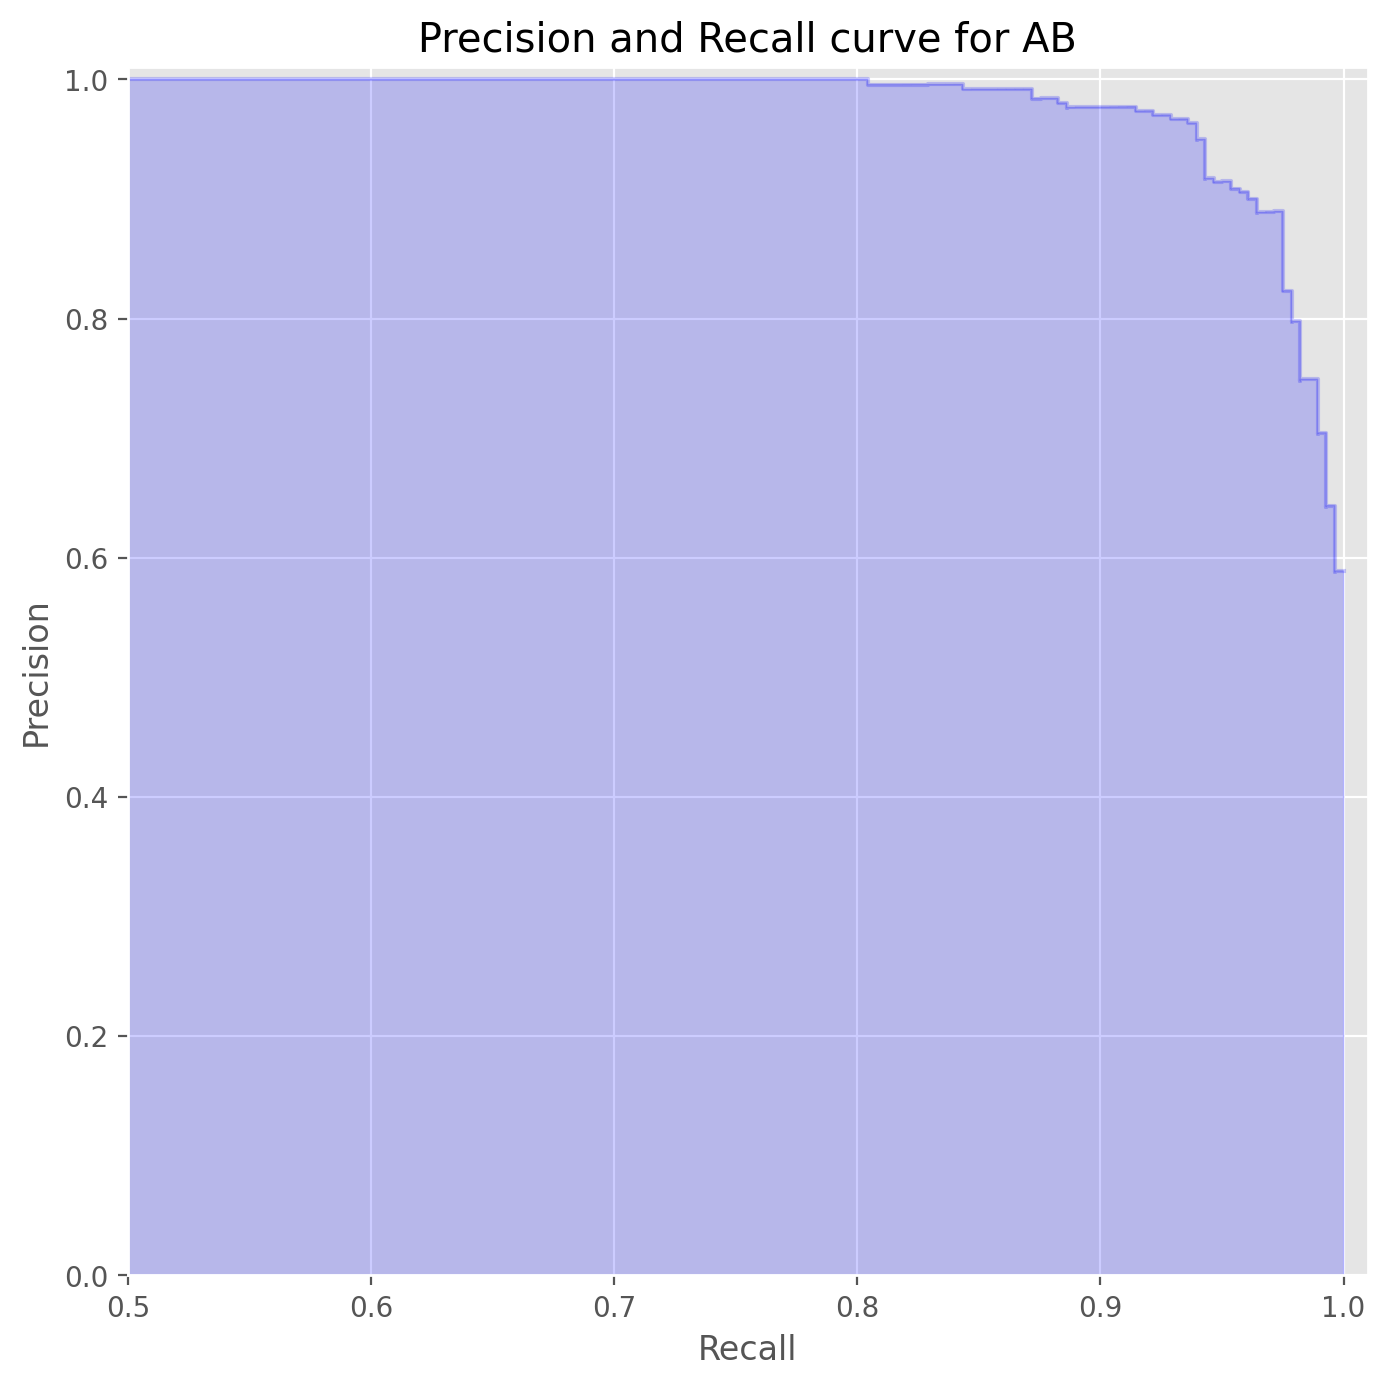

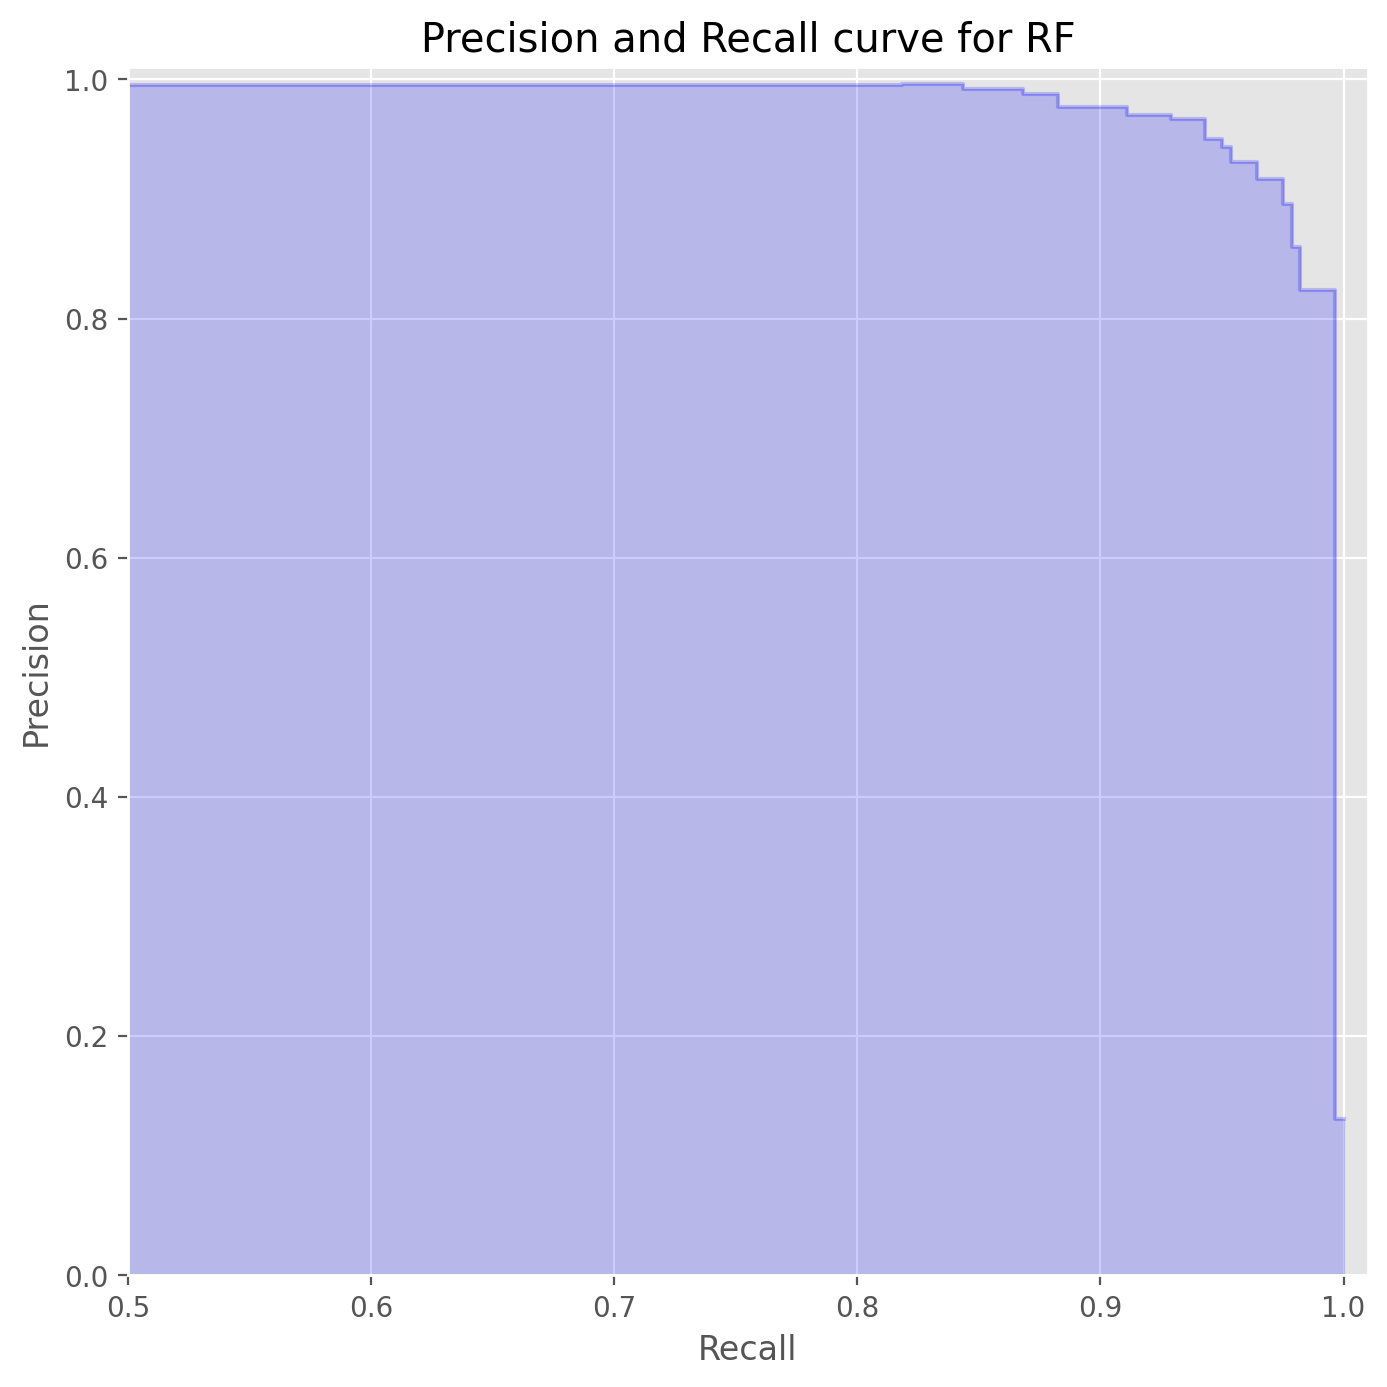

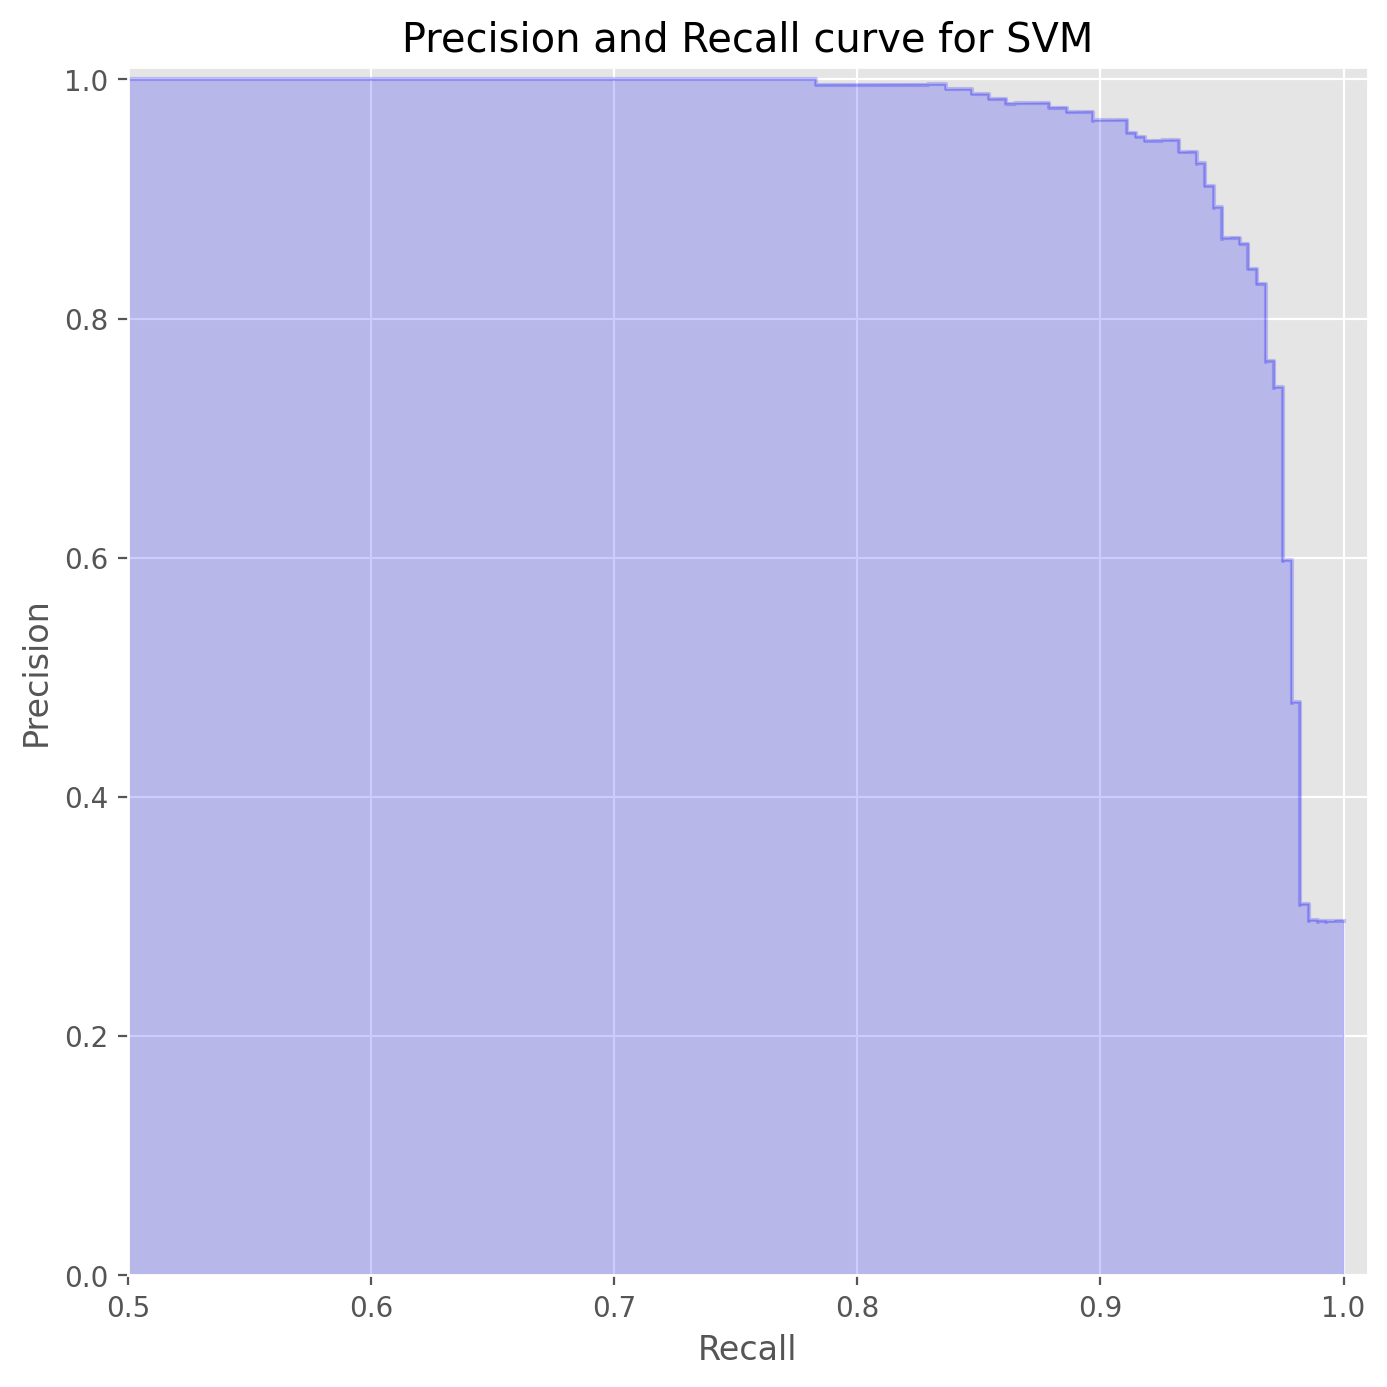

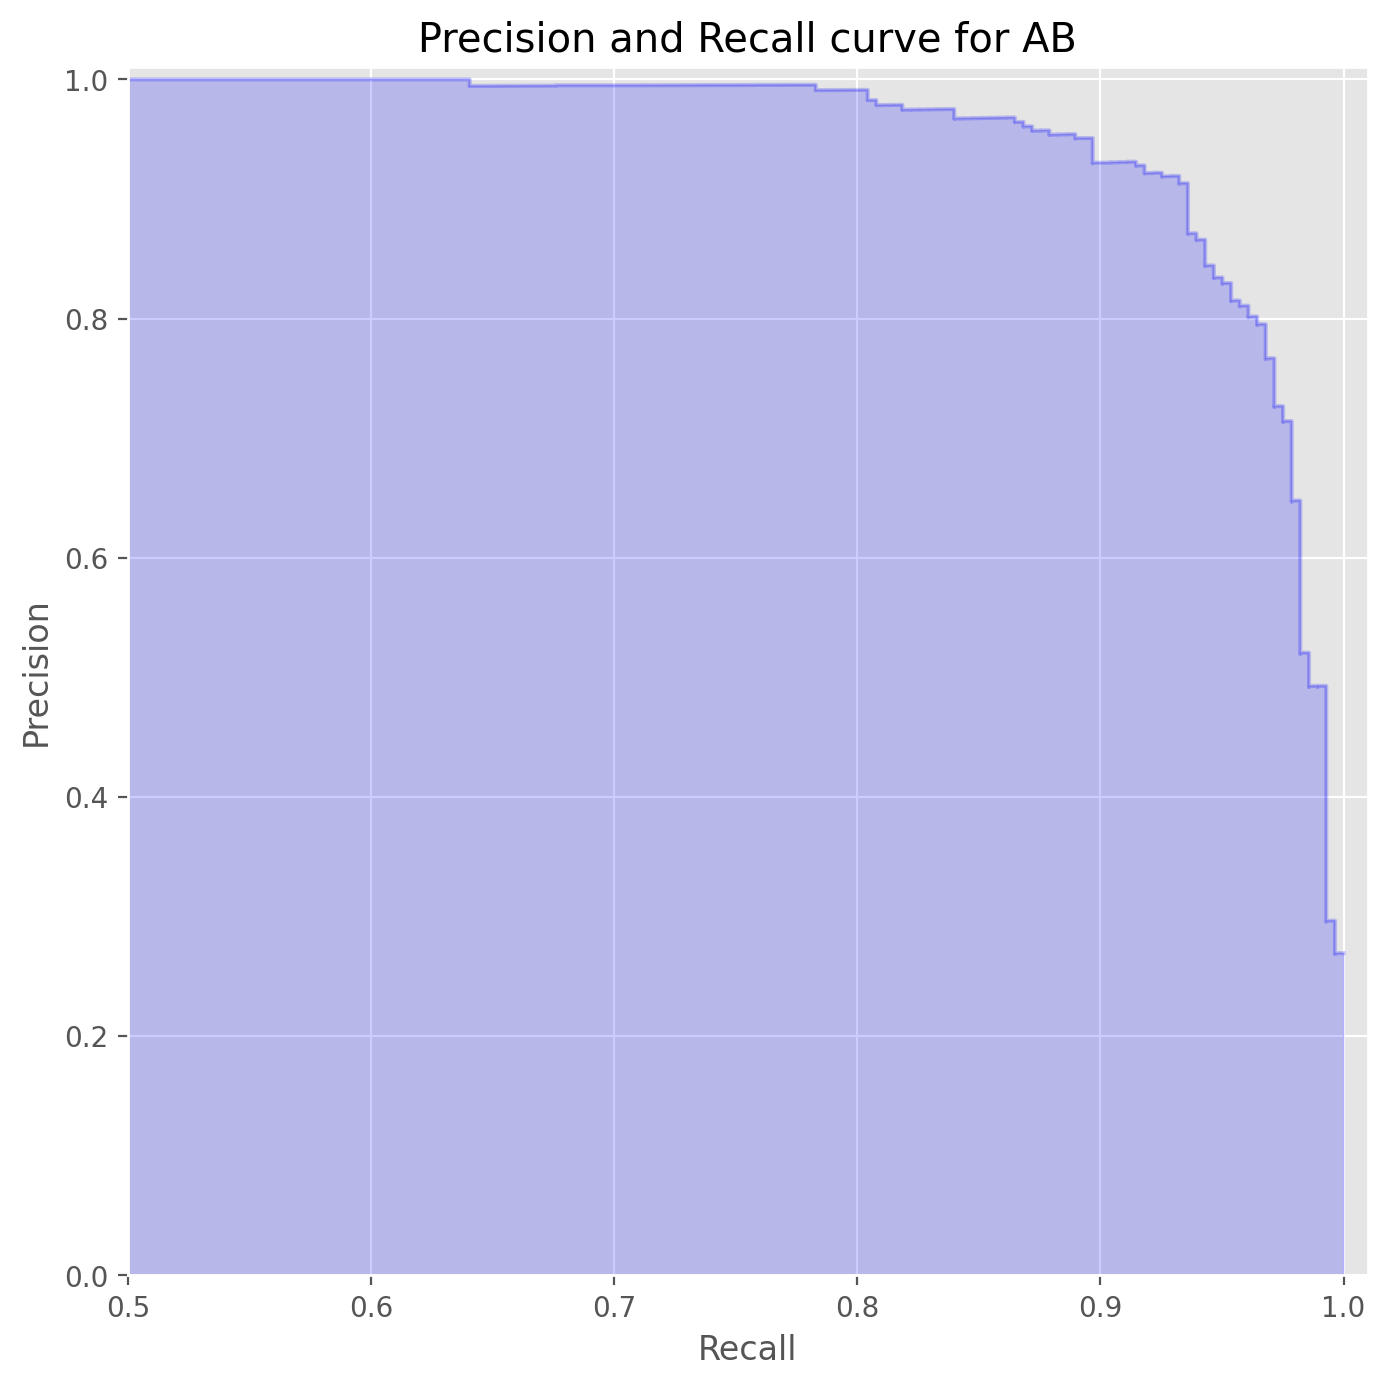

In [22]:
for train_index, test_index in kfold.split(df, x_labels):
    counter += 1
    # use the indices to split the dataframe into the training and validation 
    # segments
    X_pre_train, X_pre_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = x_labels[train_index], x_labels[test_index]
    
    # run the if statement if you would like to scale the features before
    # training. this scaling implements standard mean 0, std 1 scaling, and
    # also boxcox scaling on the 'size' feature
    if SCALING:
        X_pre_train = X_pre_train.copy()
        X_pre_test = X_pre_test.copy()
        # box-cox scaling on training data
        X_pre_train.loc[:,'size'], lmbda = stats.boxcox(\
                                                 X_pre_train['size'].copy())
        lambda_list.append(lmbda)
        # use lambda for box-cox on validation data 
        X_pre_test.loc[:,'size'] = stats.boxcox(\
                                         X_pre_test['size'].copy(), lmbda)
        # standard scaler for all features, including 'size'
        scaler = StandardScaler()
        # save the scaler reference
        scaler_list.append(scaler)
        scaler.fit(X_pre_train)
        # scale both training and validation data
        X_train = scaler.transform(X_pre_train)
        X_test = scaler.transform(X_pre_test)
    else:
        # simply assign variables to the original dataset
        X_train = X_pre_train
        X_test = X_pre_test
    #1 
    clf=RandomForestClassifier(n_estimators=20, random_state=0,warm_start=True) 
    clf.fit(X_train, y_train)
    #2
    clf2 = SVC(kernel='linear', random_state=0, gamma=1, C=0.1,probability=True) 
    clf2.fit(X_train, y_train)
    #3
    clf3=AdaBoostClassifier(n_estimators=50, learning_rate=1)
    clf3.fit(X_train, y_train)

    # make predictions
    preds = clf.predict(X_test)
    preds2 = clf2.predict(X_test)
    preds3 = clf3.predict(X_test)
    # determine accuracy
    #accuracy_list.append(accuracy_score(y_test, preds.round(), normalize=False))
    accuracy_list.append(accuracy_score(y_test, preds))
    accuracy_list2.append(accuracy_score(y_test, preds2))
    accuracy_list3.append(accuracy_score(y_test, preds3))
    # save classifier
    clf_list.append(clf)
    clf_list2.append(clf2)
    clf_list3.append(clf3)

    # find probabilities
    y_scores = clf.predict_proba(X_test)[:,1]
    y_scores2 = clf2.predict_proba(X_test)[:,1]
    y_scores3 = clf3.predict_proba(X_test)[:,1]

    # obtain precision recall matrix
    avg_precision_list.append(sklearn.metrics.average_precision_score(y_test,y_scores))
    avg_precision_list2.append(sklearn.metrics.average_precision_score(y_test,y_scores2))
    avg_precision_list3.append(sklearn.metrics.average_precision_score(y_test,y_scores3))

    p, r, thresholds = precision_recall_curve(y_test, y_scores)
    p2, r2, thresholds2 = precision_recall_curve(y_test, y_scores2)
    p3, r3, thresholds3 = precision_recall_curve(y_test, y_scores3)
    print("k_Fold " + str(counter) + " Results")
    
    # save precision for each recall value wanted
    #thresh_dict3 = {}
    #precision_dict = {}
    find_threshold_for_recall(p, r, thresholds, recalls_wanted,precision_dict,thresh_dict,y_scores,"RF confusion matrix *********")
    find_threshold_for_recall(p2, r2, thresholds2, recalls_wanted,precision_dict2,thresh_dict2,y_scores2,"SVM confusion matrix *********")
    find_threshold_for_recall(p3, r3, thresholds3, recalls_wanted,precision_dict3,thresh_dict3,y_scores3,"AB confusion matrix *********")
    
    # graph precision recall curve
    precision_recall_graph(p,r,"Precision and Recall curve for RF")
    precision_recall_graph(p2,r2,"Precision and Recall curve for SVM")
    precision_recall_graph(p3,r3,"Precision and Recall curve for AB")

    

In [23]:

# show plots if needed
# plt.show()

Print out the precisions for each recall, average precision, and accuracy

In [24]:
# transfere it to function to obtain on different algorithm
#RF 
print(" RF information")
for recall in recalls_wanted:
    print("Precision for Recall of ", end='')
    print(str(recall) +':', end='')
    print(" %.4f (±%.4f)" % (np.array(precision_dict[recall]).mean(),
                                np.array(precision_dict[recall]).std()))
print("Average Precision: %.4f (±%.4f)" % (\
                                        np.array(avg_precision_list).mean(),
                                        np.array(avg_precision_list).std()))
print("Accuracy: %.4f (±%.4f)" % (np.array(accuracy_list).mean(),
                                     np.array(accuracy_list).std()))

print(" SVM information")
for recall in recalls_wanted:
    print("Precision for Recall of ", end='')
    print(str(recall) +':', end='')
    print(" %.4f (±%.4f)" % (np.array(precision_dict2[recall]).mean(),
                                np.array(precision_dict2[recall]).std()))
print("Average Precision: %.4f (±%.4f)" % (\
                                        np.array(avg_precision_list2).mean(),
                                        np.array(avg_precision_list2).std()))
print("Accuracy: %.4f (±%.4f)" % (np.array(accuracy_list2).mean(),
                                     np.array(accuracy_list2).std()))

print(" AB information")
for recall in recalls_wanted:
    print("Precision for Recall of ", end='')
    print(str(recall) +':', end='')
    print(" %.4f (±%.4f)" % (np.array(precision_dict3[recall]).mean(),
                                np.array(precision_dict3[recall]).std()))
print("Average Precision: %.4f (±%.4f)" % (\
                                        np.array(avg_precision_list3).mean(),
                                        np.array(avg_precision_list3).std()))
print("Accuracy: %.4f (±%.4f)" % (np.array(accuracy_list3).mean(),
                                     np.array(accuracy_list3).std()))

 RF information
Precision for Recall of 0.9: 0.9882 (±0.0064)
Precision for Recall of 0.97: 0.9356 (±0.0170)
Precision for Recall of 0.99: 0.7686 (±0.0951)
Average Precision: 0.9835 (±0.0050)
Accuracy: 0.9872 (±0.0010)
 SVM information
Precision for Recall of 0.9: 0.9723 (±0.0080)
Precision for Recall of 0.97: 0.6813 (±0.1852)
Precision for Recall of 0.99: 0.3345 (±0.0960)
Average Precision: 0.9729 (±0.0076)
Accuracy: 0.9834 (±0.0005)
 AB information
Precision for Recall of 0.9: 0.9650 (±0.0187)
Precision for Recall of 0.97: 0.8143 (±0.0512)
Precision for Recall of 0.99: 0.4718 (±0.1370)
Average Precision: 0.9782 (±0.0050)
Accuracy: 0.9822 (±0.0016)


In [25]:
#grid serch on tranning only on the best model in k-fold which is RF
kfold = StratifiedKFold(n_splits=2,shuffle=True, random_state=rand_state)
kfold.get_n_splits(df, x_labels)
for train_index, test_index in kfold.split(df, x_labels):
  X_pre_train, X_pre_test = df.iloc[train_index], df.iloc[test_index]
  y_train, y_test = x_labels[train_index], x_labels[test_index]
  X_pre_train = X_pre_train.copy()
  X_pre_test = X_pre_test.copy()
  # box-cox scaling on training data
  X_pre_train.loc[:,'size'], lmbda = stats.boxcox(\
                                                 X_pre_train['size'].copy())
  lambda_list.append(lmbda)
  #use lambda for box-cox on validation data 
  X_pre_test.loc[:,'size'] = stats.boxcox(\
                                         X_pre_test['size'].copy(), lmbda)
  #standard scaler for all features, including 'size'
  scaler = StandardScaler()
  # save the scaler reference
  scaler_list.append(scaler)
  scaler.fit(X_pre_train)
  # scale both training and validation data
  X_train = scaler.transform(X_pre_train)
  X_test = scaler.transform(X_pre_test)
  # Create the parameter grid based on the results of random search 
  param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
                 }
     # Create a based model
  print("here we are")
  rf = RandomForestClassifier()
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
  grid_search.fit(X_train, y_train)
  x=grid_search.best_params_
  w=grid_search
  clf_list_last1=[]
  clf_list_last1.append(w)
  print(x)
  break
    


here we are
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 15.4min finished


{'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


# Testing on ClinVar (Optional)
For testing these models on ClinVar, the new .csv file must be loaded, and all pre-processing from above repeated

In [26]:
file = open('/content/sample_data/2_test.csv')
df = pd.read_csv(file, dtype=str)
df.drop(['genes_in_proximity','chr', 'start', 'end', 'Unnamed: 0'],
        axis=1, inplace=True)
df.drop(['repeat_Other', 'repeat_Unknown'], axis=1, inplace=True)
df = df.astype(float)
df = df[df["size"] > lower_bound]
df = df[df["size"] < upper_bound]
df['pathogenicity'] = df['pathogenicity'].replace(-1, 0)
x_labels = df['pathogenicity'].values
df.drop(['pathogenicity'], axis=1, inplace=True)
df['gene_density'] = df['number_of_genes_in_proximity'] / df['size'] * 100000
cols = [c for c in df.columns if c.lower()[:6] == 'repeat']
for col in cols:
    df[col + '_density'] = df[col] / df['size'] * 100000

cols = [c for c in df.columns if c.lower()[:4] == 'bioc' or c.lower()[:4] == 'kegg' or c.lower()[:5] == 'react']
df = df.drop(cols,axis=1)
df = df[to_be_scaled]
print("finish")

finish


Now initialize lists to store the accuracy and average precision of each model on the ClinVar testing set

In [27]:
test_accuracy_list = []
test_avg_precision_list = []

Finally use all of the 5 classifiers and their 3 threshold levels (for 90% recall, 97% recall, and 99% recall) to create predictions

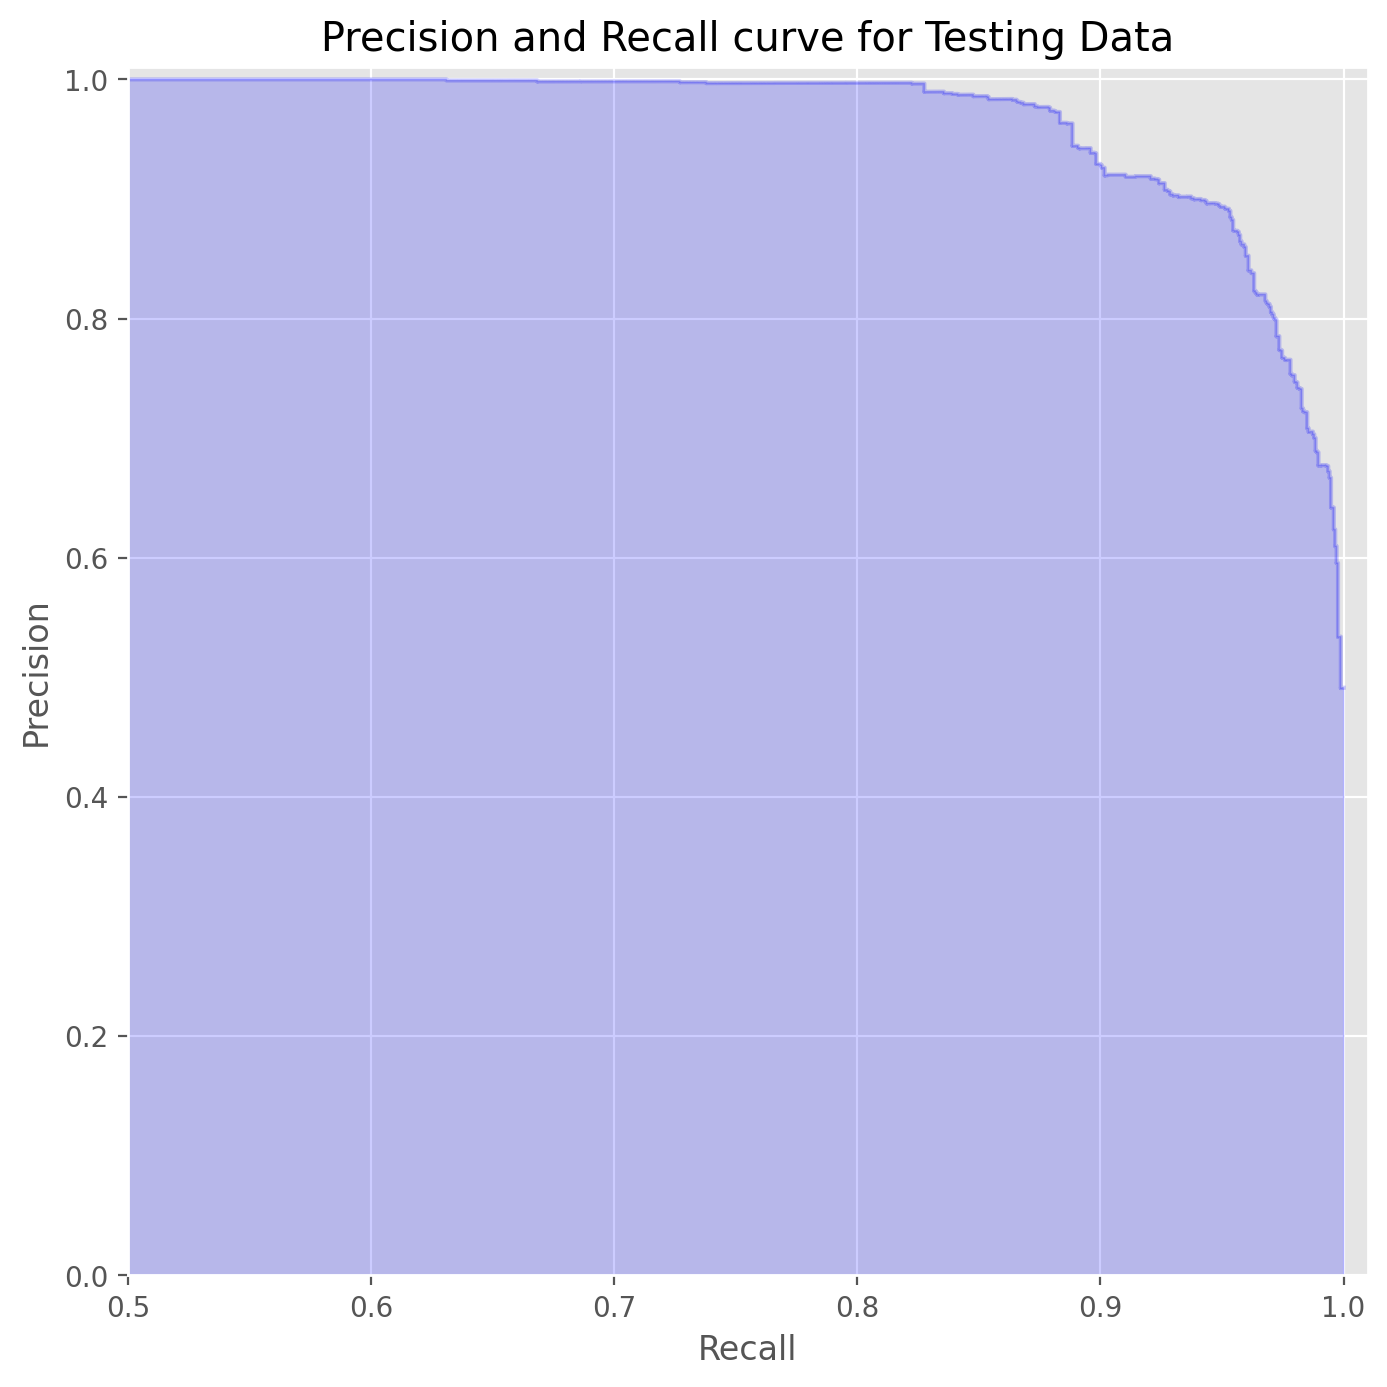

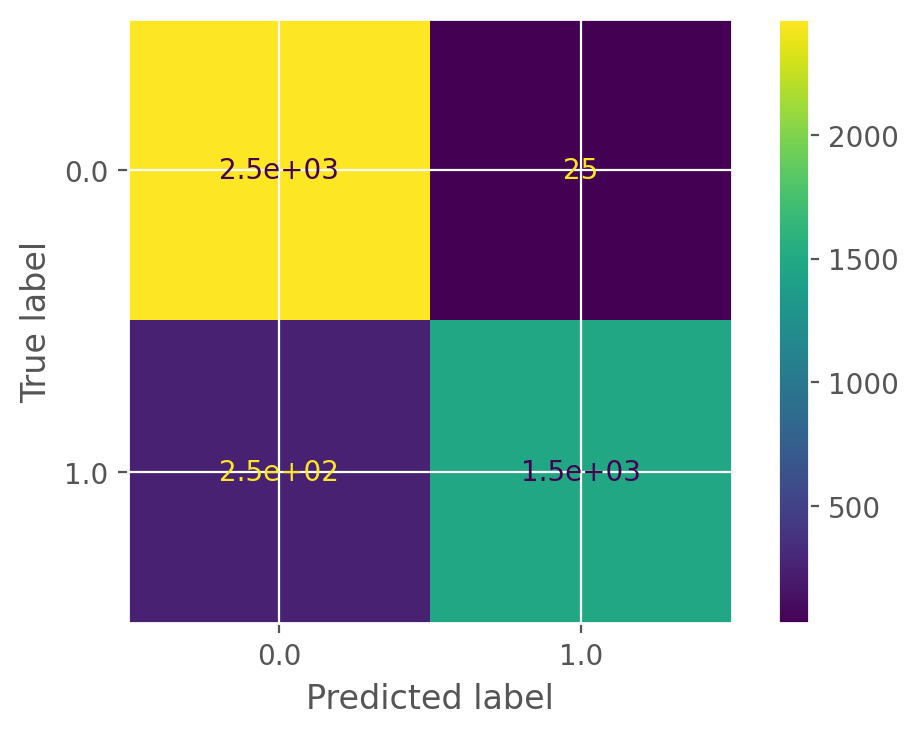

for original recall: 0.9
     pred_neg  pred_pos
neg      2488         4
pos       446      1294
for original recall: 0.97
     pred_neg  pred_pos
neg      2291       201
pos        84      1656
for original recall: 0.99
     pred_neg  pred_pos
neg      1138      1354
pos         4      1736
Test Average Precision: 0.9815 (±0.0000)
Test Accuracy: 0.9355 (±0.0000)
F1 Score for Random Forest Model: 0.9161805342339576


In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
for i in range(len(clf_list_last1)):
    clf = clf_list_last1[i]
    x_test = df.copy()
    x_test.loc[:,'size'] = stats.boxcox(x_test['size'].copy(), lambda_list[i])
    x_test = scaler_list[i].transform(x_test)
    preds = clf.predict(x_test)
    test_accuracy_list.append(accuracy_score(x_labels, preds))
    y_scores = clf.predict_proba(x_test)[:,1]
    test_avg_precision_list.append(sklearn.metrics.average_precision_score(
                                                        x_labels, y_scores))
    p, r, thresholds = precision_recall_curve(x_labels, y_scores)
    # graph precision recall curve
    precision_recall_graph(p,r,"Precision and Recall curve for Testing Data")
    plot_confusion_matrix(clf, x_test, x_labels)  
    plt.show() 
    for recall in recalls_wanted:
        print("for original recall: " + str(recall))
        y_pred_adj = [1 if y >= thresh_dict[recall][i] else 0 for y in y_scores]
        print(pd.DataFrame(confusion_matrix(x_labels, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
print("Test Average Precision: %.4f (±%.4f)" % (\
                                np.array(test_avg_precision_list).mean(),
                                np.array(test_avg_precision_list).std()))
print("Test Accuracy: %.4f (±%.4f)" % (np.array(test_accuracy_list).mean(),
                                   np.array(test_accuracy_list).std()))

x=f1_score(x_labels, preds)
print("F1 Score for Random Forest Model: "+str(x))
 